# Setup

In [ ]:
!pip install pybind11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install igraph
import igraph as ig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.4 MB/s eta 0:00:00


In [ ]:
!pip install python-louvain
import community.community_louvain as community_louvain

In [ ]:
!pip install infomap
from infomap import Infomap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install leidenalg
import leidenalg

In [ ]:
import numpy as np
import pandas as pd
import random
import time
import math
from itertools import combinations
from statistics import median
from datetime import timedelta, datetime
import uuid
from datetime import datetime, timedelta
import math
import networkx as nx
import community.community_louvain as community_louvain
from scipy.stats import zscore
from abc import ABC, abstractmethod
from networkx.algorithms import community
from sklearn.cluster import SpectralClustering

from bokeh.io import output_notebook, show, save
from bokeh.models import (
    Circle,
    MultiLine,
    Range1d,
    ColumnDataSource,
    HoverTool,
    EdgesAndLinkedNodes,
    NodesAndLinkedEdges,
    Arrow,
    NormalHead,
)
from bokeh.palettes import (
    Blues8,
    Reds8,
    Purples8,
    Oranges8,
    Viridis8,
    Spectral8,
    Plasma256,
    d3,
    Turbo256,
    Category20,
)
from bokeh.plotting import figure, from_networkx
from bokeh.transform import linear_cmap

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm
from google.colab import files
from matplotlib import patches

from plotly import express as px, graph_objects as go
from IPython.display import Audio, clear_output, display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

output_notebook()

# Utilities

In [ ]:
def calculate_time_taken(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        try:
            result = func(*args, **kwargs)
        except Exception as e:
            playErrorSound()
            print(f"An error occurred: {e}")
            raise  # Re-lança a exceção para que o código chamador possa lidar com ela se necessário
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken: {elapsed_time:.2f} seconds")
        playSound()
        return result
    return wrapper
##
def find_and_print_user_by_id(df, user_id):
    user_row = df[df['colab_user_id'] == user_id]
    if not user_row.empty:
        print(user_row)
    else:
        print(f"No row found with colab_user_id {user_id}")
###
# Play a sound
def playSound():
    sound_file = 'https://freesound.org/data/previews/80/80921_1022651-lq.mp3'
    try:
      display(Audio(sound_file, autoplay=True))
    except Exception as e:
      print("error playing sound lmao")
####
# Play a sound
def playErrorSound():
    sound_file = 'https://cdn.freesound.org/previews/450/450616_9159316-lq.mp3'
    display(Audio(sound_file, autoplay=True))
####

In [ ]:
def filter_dfs_based_on_edgelist(edgelist, colab_comments, colab_likes, colab_updown):
    # Combine unique values from 'source' and 'target' columns
    user_ids_from_edgelist = set(edgelist['source']).union(set(edgelist['target']))

    # Function to filter DataFrame based on user IDs
    def filter_df(df):
        return df[(df['colab_user_id_from'].isin(user_ids_from_edgelist)) |
                  (df['colab_user_id_to'].isin(user_ids_from_edgelist))]

    # Apply the filter function to each DataFrame
    filtered_colab_comments = filter_df(colab_comments)
    filtered_colab_likes = filter_df(colab_likes)
    filtered_colab_updown = filter_df(colab_updown)

    return filtered_colab_comments, filtered_colab_likes, filtered_colab_updown

# Network Community Detection Strategies

In [ ]:
class CommunityStrategy:
    def detect_communities(self, G):
        raise NotImplementedError

class GreedyModularityCommunityStrategy(CommunityStrategy):
    def detect_communities(self, G):
        return list(nx.algorithms.community.greedy_modularity_communities(G))

class SpectralClusteringStrategy(CommunityStrategy):
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def detect_communities(self, G):
        adjacency_matrix = nx.to_numpy_array(G)
        spectral_model = SpectralClustering(
            n_clusters=self.n_clusters, affinity='precomputed')
        labels = spectral_model.fit_predict(adjacency_matrix)
        communities = []
        for label in np.unique(labels):
            nodes = list(np.where(labels == label)[0])
            communities.append(set(nodes))
        return communities

class InfomapStrategy(CommunityStrategy):
    def detect_communities(self, G):
        infomap_model = Infomap()
        for edge in G.edges():
            infomap_model.addLink(*edge)
        infomap_model.run()
        communities = []
        for node in infomap_model.iterTree():
            if node.isLeaf():
                communities.append(set(node.physicalId))
        return communities

class LouvainCommunityStrategy(CommunityStrategy):
    def detect_communities(self, G):
        partitions = community_louvain.best_partition(G.to_undirected())
        values = set(partitions.values())
        communities = [set([key for key in partitions.keys()
                           if partitions[key] == val]) for val in values]
        return communities

class LeidenClusteringStrategy(CommunityStrategy):
    def __init__(self, algo=leidenalg.RBERVertexPartition, resolution=1.0, num_iterations=10):
        self.algo = algo
        self.resolution = resolution
        self.num_iterations = num_iterations

    def detect_communities(self, G):
        g = ig.Graph.from_networkx(G)
        # Set the 'name' attribute for each vertex in the igraph graph
        g.vs["name"] = list(G.nodes())
        # Find the communities using the Leiden algorithm with the specified parameters
        if self.algo != leidenalg.ModularityVertexPartition:
            partition = leidenalg.find_partition(
                g, self.algo, n_iterations=self.num_iterations)
        else:
            partition = leidenalg.find_partition(g, self.algo)
        # Extract the communities
        network_communities = [list(partition.subgraph(
            i).vs["name"]) for i in range(len(partition))]
        return network_communities

class GirvanNewmanCommunityStrategy(CommunityStrategy):
    def detect_communities(self, G):
        def find_best_edge(G0):
            # Function to find the edge with the highest betweenness centrality.
            edge_betweenness = nx.edge_betweenness_centrality(G0)
            sorted_edge_betweenness = sorted(
                edge_betweenness.items(), key=lambda x: x[1], reverse=True)
            return sorted_edge_betweenness[0][0]

        def girvan_newman_step(G):
            # Function to perform one step of the Girvan-Newman algorithm.
            if len(G.edges) == 0:
                return []

            initial_components = nx.number_connected_components(G)
            edge_to_remove = find_best_edge(G)
            G.remove_edge(*edge_to_remove)
            new_components = nx.number_connected_components(G)

            if new_components > initial_components:
                return [c for c in nx.connected_components(G)]
            else:
                return girvan_newman_step(G)

        communities = girvan_newman_step(G)
        return communities

In [ ]:
def form_valid_partition(communities, G):
    valid_partition = []
    covered_nodes = set()
    for community in communities:
        new_community = community - covered_nodes
        if new_community:
            valid_partition.append(new_community)
            covered_nodes.update(new_community)
    remaining_nodes = set(G.nodes) - covered_nodes
    if remaining_nodes:
        valid_partition.append(remaining_nodes)
    return valid_partition
##

In [ ]:
def leiden_communities(G, algo=leidenalg.RBERVertexPartition, resolution=5.0, num_iterations=10):
  g = ig.Graph.from_networkx(G)

  # Set the 'name' attribute for each vertex in the igraph graph
  g.vs["name"] = list(G.nodes())

  # Find the communities using the Leiden algorithm with the specified resolution parameter
  #if(algo != leidenalg.ModularityVertexPartition or algo != leidenalg.SignificanceVertexPartition):
  #  partition = leidenalg.find_partition(g, algo, n_iterations=num_iterations, resolution_parameter=resolution)
  #else:
  partition = leidenalg.find_partition(g, algo)

  # Extract the communities
  network_communities = [list(partition.subgraph(i).vs["name"]) for i in range(len(partition))]
  return network_communities
##
#G = nx.karate_club_graph()
#result = leiden_communities(G)
#result

In [ ]:
def infomap_communities(G):
    im = infomap.Infomap()

    # Add nodes and links (edges) to the Infomap instance
    for node in G.nodes():
        im.add_node(node)
    for u, v in G.edges():
        im.add_link(u, v)

    # Run the Infomap algorithm
    im.run()

    # Extract the communities
    network_communities = {}
    for node in im.tree:
        if node.is_leaf:
            network_communities.setdefault(node.module_id, []).append(node.node_id)

    # Convert the dictionary values to a list of lists
    communities_list = list(network_communities.values())
    return communities_list

# Example usage:
#G = nx.karate_club_graph()
#result = infomap_communities(G)
#print(result)

In [ ]:
#### @calculate_time_taken
def analyze_communities(G, algorithm='greedy', **kwargs):
    # Define a dictionary mapping algorithm names to functions
    algorithms = {
        'greedy': nx.community.greedy_modularity_communities,
        'naive': nx.community.naive_greedy_modularity_communities,
        'label_propagation': nx.community.label_propagation_communities,
        'louvain': nx.community.louvain_communities,
        'community_louvain': community_louvain.best_partition,
        'leiden': leiden_communities,
        'girvan_newman': nx.community.girvan_newman,
        'asyn_lpa': nx.community.asyn_lpa_communities,
        'k_clique': nx.community.k_clique_communities,
        'infomap': infomap_communities
    }

    # Get the selected algorithm function from the dictionary
    algo_func = algorithms.get(algorithm)
    if algo_func is None:
        raise ValueError(f"Invalid algorithm name: {algorithm}")

    # Convert the graph to undirected if necessary
    if algorithm in {'girvan_newman', 'k_clique', 'community_louvain', 'naive', 'label_propagation'}:
        G = G.to_undirected()

    # Find communities using the selected algorithm
    if algorithm == 'girvan_newman':
        best_modularity = -1
        best_communities = None
        for communities in algo_func(G, **kwargs):
            modularity = nx.community.modularity(G, communities)
            if modularity > best_modularity:
                best_modularity = modularity
                best_communities = communities
        network_communities = list(best_communities)
    elif algorithm == 'k_clique':
        network_communities = list(algo_func(G, **kwargs))
        network_communities = form_valid_partition(network_communities, G)
    elif algorithm == 'community_louvain':
        partition = community_louvain.best_partition(G)
        modularity_score = community_louvain.modularity(partition, G)
        communities = {}
        for node, community_id in partition.items():
            communities.setdefault(community_id, []).append(node)
        network_communities = list(communities.values())
    else:
        network_communities = list(algo_func(G, **kwargs))
    #print(network_communities)
    if (algorithm != 'community_louvain'):
        network_communities = [list(community)
                               for community in network_communities]
        modularity_score = nx.community.modularity(G, network_communities)

    min_size = 2
    max_size = 50
    network_communities = [community for community in network_communities if (len(community) >= min_size) & (len(community) <= max_size)]
    print(f"Number of communities: {len(network_communities)}")

    largest_community = max(network_communities, key=len)
    smallest_community = min(network_communities, key=len)
    avg_size = sum(len(community)
                   for community in network_communities) / len(network_communities)

    return {
        "communities": network_communities,
        "number_of_communities": len(network_communities),
        "largest_community_size": len(largest_community),
        "smallest_community_size": len(smallest_community),
        "average_community_size": avg_size,
        "modularity_score": modularity_score
    }

In [ ]:
###### @calculate_time_taken
def analyse_communities(G, strategy):
  network_communities = strategy.detect_communities(G)
  network_communities = [community for community in network_communities if len(community) >= 3]
  largest_community = max(network_communities, key=len)
  smallest_community = min(network_communities, key=len)
  avg_size = sum(len(community)
                  for community in network_communities) / len(network_communities)

  return {
      "communities": network_communities,
      "number_of_communities": len(network_communities),
      "largest_community_size": len(largest_community),
      "smallest_community_size": len(smallest_community),
      "average_community_size": avg_size
  }

# Echo Chamber Classification

In [ ]:
metrics_training_url = "https://drive.google.com/uc?export=download&id=1UBx1lTHipKqwVwFO7Sz4WAu-PsgQmFdG"
metrics_training = pd.read_csv(metrics_training_url, sep=',', decimal='.', header=0, low_memory=False)
metrics_training

,graph_size,is_echo_chamber,echo_chamber_strength,density,homogeneity,external_connections,ecc,gec,average_exposure,size
0,100,0,4.9858,0.6,0.4711,0.7200,0.3333,0.1514,0.6667,6
1,100,0,3.1778,0.7,0.0000,0.7368,0.0000,0.1514,0.2000,5
2,100,0,5.1329,0.7,0.5118,0.6667,0.8000,0.1514,0.4857,5
3,100,0,6.2459,0.7,0.6623,0.7368,0.4000,0.1514,0.4400,5
4,100,0,8.4499,0.7,1.0000,0.7000,0.0000,0.1514,0.5000,5
...,...,...,...,...,...,...,...,...,...,...
576,800,1,4.1491,1.0,1.0000,0.0577,1.3333,0.2805,0.3611,3
577,800,1,4.1463,1.0,1.0000,0.0566,1.6667,0.2805,0.3704,3
578,800,0,2.3762,1.0,0.0000,0.5000,0.3333,0.2805,0.5000,3
579,800,0,2.3806,1.0,0.0000,0.5000,0.3333,0.2805,0.6667,3


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

class RandomForestEchoClassifier:

    def __init__(self):
        self.model = RandomForestClassifier()
        self.features = ['graph_size', 'echo_chamber_strength', 'density', 'homogeneity',
                         'external_connections', 'ecc', 'gec', 'average_exposure', 'size']

    def load_data(self, dataframe):
        # Assuming the dataframe is already loaded into the environment as `metrics_training`
        self.X_train = dataframe[self.features]
        self.y_train = dataframe['is_echo_chamber']

    def train(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self, input_dict):
        # Validate and convert the input_dict to a dataframe with a single row
        input_df = pd.DataFrame([input_dict])
        # Make sure the input data has the same features as the training data
        input_df = input_df[self.features]
        # Predict the class (1 or 0 for is_echo_chamber)
        prediction = self.model.predict(input_df)
        # Return the prediction as a scalar (1 or 0)
        return prediction[0]

# Create an instance of the classifier
echo_chamber_classifier = RandomForestEchoClassifier()
# Load the data into the classifier
echo_chamber_classifier.load_data(metrics_training)
echo_chamber_classifier.train()
# A sample input for prediction
#sample_input = {'graph_size':50, 'echo_chamber_strength': 10.9226, 'density': 1.0, 'homogeneity': 1.0, 'external_connections': 0.8, 'ecc': 1.2, 'gec': 0.1367, 'average_exposure': 0.5, 'size': 5}
sample_input = {'graph_size':50, 'echo_chamber_strength': 5.014, 'density': 0.7, 'homogeneity': 0.3855, 'external_connections': 0.7368, 'ecc': 0.2, 'gec': 0.1367, 'average_exposure': 0.7, 'size': 5}

# Make a prediction with the sample input
prediction = echo_chamber_classifier.predict(sample_input)

# Output the prediction
prediction


0

In [ ]:
class RandomForestEchoClassifier:

    def __init__(self, dataframe):
        self.model = RandomForestClassifier()
        self.features = ['graph_size', 'echo_chamber_strength', 'density', 'homogeneity',
                         'external_connections', 'ecc', 'gec', 'average_exposure', 'size']
        self.load_data(dataframe)
        self.train()

    def load_data(self, dataframe):
        self.X_train = dataframe[self.features]
        self.y_train = dataframe['is_echo_chamber']

    def train(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self, input_dict):
        input_df = pd.DataFrame([input_dict])
        input_df = input_df[self.features]
        prediction = self.model.predict(input_df)
        return prediction[0]

In [ ]:
# Now creating the EchoChambersClassifier
class EchoChambersClassifier:

    def __init__(self, training_data):
        # Initialize and train the RandomForestEchoClassifier
        self.classifier = RandomForestEchoClassifier(training_data)

    def analyse_metrics(self, metrics_list):
        result_positions = []
        # Loop through each metric in the metrics_list
        for index, metric in enumerate(metrics_list):
            prediction = self.classifier.predict(metric)
            # If the classifier returns 1, add the position to the result array
            if prediction == 1:
                result_positions.append(index)
        return result_positions

In [ ]:
from scipy.signal import find_peaks

class EchoChambersPeakClassifier(EchoChambersClassifier):

    def __init__(self):
        # Initialize this class without calling the parent class constructor
        pass

    def analyse_metrics(self, metrics_list):
        # Extract the metric of interest (e.g., 'echo_chamber_strength')
        data = [metrics['echo_chamber_strength'] for metrics in metrics_list]

        # Find peaks in the data
        peaks, _ = find_peaks(data, height=0)  # Adjust 'height' as needed

        # Identify echo chamber indices based on detected peaks
        echo_chamber_indices = peaks.tolist()

        return echo_chamber_indices


In [ ]:
echo_chamber_metrics_classifier = EchoChambersClassifier(metrics_training)
echo_chamber_metrics_classifier.analyse_metrics([{'graph_size': 58, 'echo_chamber_strength': 7.1548, 'density': 0.8333, 'homogeneity': 0.8333, 'external_connections': 0.6667, 'ecc': 0.0, 'gec': 0.1608, 'average_exposure': 0.375, 'size': 4},{'graph_size': 58, 'echo_chamber_strength': 11.7092, 'density': 1.0, 'homogeneity': 1.0, 'external_connections': 0.8615, 'ecc': 1.625, 'gec': 0.1608, 'average_exposure': 0.7083, 'size': 8}])

[1]

# Echo Chamber Detector Class

In [ ]:
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

In [ ]:
class EchoChamberDetector:
    def __init__(self, nodes_df, edges_df, events_df, colab_comments_df, colab_likes_df, colab_updown_df, strategy, classifier=None, communities=None):
        self.nodes = nodes_df
        self.edges = edges_df
        self.events = events_df
        self.colab_comments = colab_comments_df
        self.colab_likes = colab_likes_df
        self.colab_updown = colab_updown_df
        self.G = nx.from_pandas_edgelist(self.edges, 'source', 'target', create_using=nx.DiGraph())
        self.strategy = strategy
        self.classifier = classifier
        self.communities = communities
        self.min_community_size = 3
        self.echo_chambers = []

    def get_unique_event_types_for_user_from_df(self, user_id, dataframe):
        return dataframe[dataframe['colab_user_id_from'] == user_id]['event_type_id'].unique()

    def get_all_unique_event_types_for_user(self, user_id):
        event_types_from_events = self.events[self.events['colab_user_id']
                                              == user_id]['event_type_id'].unique()
        event_types_from_comments = self.get_unique_event_types_for_user_from_df(
            user_id, self.colab_comments)
        event_types_from_likes = self.get_unique_event_types_for_user_from_df(
            user_id, self.colab_likes)
        event_types_from_updown = self.get_unique_event_types_for_user_from_df(
            user_id, self.colab_updown)
        all_event_types = np.concatenate([event_types_from_events, event_types_from_comments,
                                          event_types_from_likes, event_types_from_updown])
        # Convert all elements to strings
        all_event_types_str = [str(event_type) for event_type in all_event_types]

        return np.unique(all_event_types_str)

    def get_all_scores_for_user(self, user_id):
        scores_from_events = self.events[self.events['colab_user_id']
                                         == user_id]['score'].values
        updown_votes = self.colab_updown[self.colab_updown['colab_user_id_from'] == user_id]
        #scores_from_updown = np.where(updown_votes['vote'] == 'down', -1, 1)
        scores_from_updown = []
        all_scores = np.concatenate([scores_from_events, scores_from_updown])
        return all_scores

    def get_persona_for_user(self, user_id):
        user_events = self.events[self.events['colab_user_id'] == user_id]
        if not user_events.empty:
            return user_events['persona'].iloc[0]
        else:
            return None

    def get_events_created_by_user(self, user_id):
        return self.events[self.events['colab_user_id'] == user_id]

    def calculate_community_density(self, community):
        edges = [(n1, n2) for n1 in community for n2 in community if n1 !=
                 n2 and self.G.has_edge(n1, n2)]
        density = len(edges) / (len(community) * (len(community) - 1))
        return density

    def calculate_modularity(self, G):
        """
        Calcula a modularidade do grafo.
        :param G: O grafo.
        :return: O valor da modularidade.
        """
        ug = G.to_undirected()
        # Detecção de comunidades usando o algoritmo de Louvain
        partition = community_louvain.best_partition(ug)

        # Calculando a modularidade
        modularity = community_louvain.modularity(partition, ug)
        #print(f"graph modularity {modularity}")
        return modularity

    def calculate_global_gec(self):
        total_gec = 0
        total_weight = 0

        for community in self.communities:
            community_size = len(community)
            community_gec = self.calculate_community_gec(community)

            # Weighted sum of GEC, weighted by the size of each community
            total_gec += community_gec * community_size
            total_weight += community_size

        # Calculate the weighted average GEC
        global_gec = total_gec / total_weight if total_weight > 0 else 0
        #print(f"Global Echo Chamber Coefficient {global_gec}")
        return global_gec

    def calculate_average_external_connections(self, G):
        external_connections = {}  # A dictionary to store external connections for each node

        # Initialize external connections count to 0 for all nodes
        for node in G.nodes():
            external_connections[node] = 0

        # Calculate external connections for each node
        for edge in G.edges():
            source, target = edge
            if source not in G.nodes() or target not in G.nodes():
                # One of the nodes is external, increment external connections count
                if source not in G.nodes():
                    external_connections[target] += 1
                if target not in G.nodes():
                    external_connections[source] += 1

        # Calculate the total external connections count
        total_external_connections = sum(external_connections.values())

        # Calculate the average external connections
        average_external_connections = total_external_connections / len(G.nodes())

        return average_external_connections

    def calculate_external_connections(self, community):
        external_connections = 0
        possible_connections = 0
        for node in community:
            for neighbor in self.G.neighbors(node):
                if neighbor not in community:
                    external_connections += 1
                possible_connections += 1
        if possible_connections > 0:
            factor = 1.0 - (external_connections / possible_connections)
        else:
            factor = 1.0
        return factor

    def calculate_homogeneity_of_opinions(self,community):
        # Obter todas as pontuações de opinião dos membros da comunidade
        all_scores = [score for user in community for score in self.get_all_scores_for_user(user)]

        # Filtrar out NaN values
        all_scores = [score for score in all_scores if not np.isnan(score)]
        #print("ALL SCORES", all_scores)

        # Se não houver pontuações suficientes
        if len(all_scores) <= 1:
            return 0

        # Calculate weighted homogeneity
        total_weight = len(all_scores)
        weighted_std = np.std(all_scores) * total_weight

        # Normalize the weighted std to a value between 0 and 1
        normalized_weighted_std = 1 / (1 + weighted_std)

        return normalized_weighted_std


    def calculate_echo_chamber_metrics(self, community):
        print(f"calculate_echo_chamber_metrics {community}")
        # Calculate individual metrics
        density = self.calculate_community_density(community)
        homogeneity = self.calculate_homogeneity_of_opinions(community)
        external_connections = self.calculate_external_connections(community)
        influencers = self.calculate_community_influence(self.G, community)
        ecc = self.calculate_ecc_for_community(community)
        gec = self.global_gec  # Global Echo Chamber factor
        average_exposure = self.calculate_community_exposure(community)

        # Echo chamber strength calculation
        strength = np.exp(
            self.beta1 * density +
            self.beta2 * homogeneity +
            self.beta3 * external_connections +
            self.beta4 * influencers +
            self.beta5 * average_exposure  +
            self.beta6 * gec +
            self.beta7 * ecc
        )

        # Create a dictionary to store all metrics including strength
        echo_chamber_metrics = {
            'graph_size': len(self.G.nodes()),
            'echo_chamber_strength': round(strength,4),
            'density': round(density,4),
            'homogeneity': round(homogeneity,4),
            'external_connections': round(external_connections,4),
            'ecc': round(ecc,4),
            'gec': round(gec,4),
            'average_exposure': round(average_exposure,4),
            'size': len(community)
        }
        print(f"metrics {echo_chamber_metrics}")
        return echo_chamber_metrics


    def calculate_graph_echo_chamber_strength(self):
        #print("Calculating graph echo chamber strength...")
        # Extract the largest connected component as a subgraph
        largest_cc = max(nx.connected_components(self.G.to_undirected() ), key=len)
        subgraph = self.G.subgraph(largest_cc)

        # Filter nodes with a degree (in + out in a directed graph) of 3 or more
        filtered_nodes = [node for node, degree in subgraph.degree() if degree >= 3]

        # Create a subgraph with only those filtered nodes
        filtered_subgraph = subgraph.subgraph(filtered_nodes)
        community = list(filtered_subgraph.nodes)
        ##
        density = nx.density(self.G)
        #print(f"graph density: {density}")
        homogeneity = self.calculate_homogeneity_of_opinions(community)
        #print(f"graph homogeneity: {homogeneity}")
        try:
            eig_centralities = nx.eigenvector_centrality_numpy(G, max_iter=1000, tol=1e-03)
        except:
            #print("ARPACK did not converge, falling back to largest component or different method")
            # Handle the error by using the largest connected component, for example
            largest_cc = max(nx.connected_components(self.G.to_undirected()), key=len)
            subgraph = self.G.subgraph(largest_cc)
            eig_centralities = nx.eigenvector_centrality_numpy(subgraph, max_iter=1000, tol=1e-03)
        #
        influencers = median(eig_centralities.values())
        external_connections = self.calculate_average_external_connections(self.G)
        #print(f"graph external_connections: {external_connections}")
        ecc = self.calculate_community_ecc(community)
        #print(f"graph ecc: {ecc}")
        self.global_gec = self.calculate_global_gec()
        #print(f"graph gec: {gec}")
        average_exposure = self.calculate_community_exposure(community)
        #print(f"graph average_exposure: {average_exposure}")
        strength = np.exp(
            self.beta1 * density +
            self.beta2 * homogeneity +
            self.beta3 * external_connections +
            self.beta4 * influencers +
            self.beta5 * average_exposure +
            self.beta6 * self.global_gec+
            self.beta7 * ecc
        )
        #print(f"Graph Echo Chamber Strength {strength}")
        return strength

    def calculate_community_influence(self, G, community_nodes):
        try:
            eig_centralities = nx.eigenvector_centrality_numpy(G, max_iter=1000, tol=1e-03)
        except:
            #print("ARPACK did not converge, falling back to largest component or different method")
            # Handle the error by using the largest connected component, for example
            largest_cc = max(nx.connected_components(G), key=len)
            subgraph = G.subgraph(largest_cc)
            eig_centralities = nx.eigenvector_centrality_numpy(subgraph, max_iter=1000, tol=1e-03)

        # Calculate influence scores for nodes in the community
        community_influence_scores = {node: eig_centralities[node] for node in community_nodes}

        # Calculate the community-level influence score (e.g., average)
        community_influence_score = sum(community_influence_scores.values()) / len(community_nodes)

        # Normalize the influence score
        max_influence_score = max(eig_centralities.values())
        normalized_influence_factor = community_influence_score / max_influence_score

        return normalized_influence_factor

    def is_echo_chamber(self, community):
        if not hasattr(self, 'graph_strength'):
          self.graph_strength = self.calculate_graph_echo_chamber_strength()
        community_strength = self.calculate_echo_chamber_strength(community)
        return community_strength >= self.graph_strength

    def derive_betas(self, G):
        #print("Deriving Betas...")
        # Beta1 - Coeficiente de Agrupamento Médio
        avg_clustering_coeff = nx.average_clustering(G)
        beta1 = avg_clustering_coeff  # Ou um valor inicial de 0.171, conforme o contexto

        # Beta2 - Homogeneidade das Opiniões
        num_communities = len(list(nx.community.greedy_modularity_communities(G)))
        beta2 = 1  # Ou um valor inicial de 1/352

        # Beta3 - Conexões Externas
        num_weakly_connected_components = nx.number_weakly_connected_components(G)
        beta3 = 1 / num_weakly_connected_components  # Ou um valor inicial de 1/329

        # Bfeta4 - Efeito dos Influenciadores
        try:
            eig_centralities = nx.eigenvector_centrality_numpy(G, max_iter=1000, tol=1e-03)
        except:
            #print("ARPACK did not converge, falling back to largest component or different method")
            # Handle the error by using the largest connected component, for example
            largest_cc = max(nx.connected_components(G), key=len)
            subgraph = G.subgraph(largest_cc)
            eig_centralities = nx.eigenvector_centrality_numpy(subgraph, max_iter=1000, tol=1e-03)
        median_centrality = median(eig_centralities.values())
        beta4 = median_centrality
        # Beta5 - Exposição Média
        if nx.is_strongly_connected(G):
            avg_path_length = nx.average_shortest_path_length(G)
        else:
            largest_cc = max(nx.strongly_connected_components(G), key=len)
            subgraph = G.subgraph(largest_cc)
            avg_path_length = nx.average_shortest_path_length(subgraph)
        beta5 = avg_path_length / len(self.G.nodes)
        # Beta6 - GEC (Modularidade)
        # Nota: Modularidade pode ser calculada usando algoritmos de detecção de comunidades
        modularity = self.calculate_modularity(G)
        beta6 = modularity  # Ou um valor inicial de 0.683
        beta7 = 1 / len(self.G.nodes)

        return beta1, beta2, beta3, beta4, beta5, beta6, beta7

    def calculate_community_ecc(self, community):
        scores = [self.get_all_scores_for_user(member) for member in community]
        all_scores = [score for sublist in scores for score in sublist]
        if not all_scores or np.all(np.isnan(all_scores)):
            return 0
        ecc = np.nanstd(all_scores)
        #print(f"calculate_community_ecc {ecc}")
        return ecc

    def calculate_ecc_for_community(self, community):
        total_contribution = 0

        for member in community:
            user_events = self.get_events_created_by_user(member)
            #print(f"user_events {user_events}")
            user_contribution = 0

            for index, row in user_events.iterrows():
                # Avalie a contribuição do evento com base em score e persona
                event_contribution = self.evaluate_event_contribution(row, community)
                user_contribution += event_contribution

            total_contribution += user_contribution

        # ECC da comunidade como um todo
        ecc = total_contribution / len(community)
        #print(f"ecc {ecc}")
        return ecc

    def evaluate_event_contribution(self, event, community):
        scores = [self.get_all_scores_for_user(member) for member in community]
        all_scores = [score for sublist in scores for score in sublist]
        if not all_scores or np.all(np.isnan(all_scores)):
            return 0
        scores = all_scores
        personas = [self.get_persona_for_user(member) for member in community]
        #print(f"scores {scores}")
        #print(f"personas {personas}")
        event_score = event['score']  # Score do evento
        event_persona = event['persona']  # Persona do evento
        #print(f"event_score {event_score}")
        #print(f"event_persona {event_persona}")
        if(event_score > 0): event_score = 1
        else: event_score = -1

        # Assuming you have already defined 'scores' and 'personas' for the community
        positive_scores = [score for score in scores if not np.isnan(score) and score > 0]
        negative_scores = [score for score in scores if not np.isnan(score) and score < 0]

        # Calculate the predominant score (positive or negative)
        predominant_score = 1 if len(positive_scores) > len(negative_scores) else -1 if len(negative_scores) > len(positive_scores) else 0
        #print(f"predominant_score {predominant_score}")
        non_none_personas = [persona for persona in personas if persona is not None]

        if non_none_personas:
            count_ones = non_none_personas.count(1)
            count_zeros = non_none_personas.count(0)

            # Calculate the predominant persona (1 or 0)
            predominant_persona = 1 if count_ones > count_zeros else 0 if count_zeros > count_ones else None
        else:
            predominant_persona = None
        #print(f"predominant_persona {predominant_persona}")
        # Compare o evento com as características predominantes da comunidade
        if event_score == predominant_score and event_persona == predominant_persona:
            #print("event contributes to polarization")
            return 1  # Evento contribui positivamente
        else:
            #print("event DOES NOT contribute to polarization")
            return 0  # Evento não contribui

    def calculate_community_gec(self, community):
        #print("Calculating all scores...")
        scores = [self.get_all_scores_for_user(member) for member in community]

        #print("Flattening all scores...")
        # Flatten the list, ignoring empty arrays and replacing NaNs with 0
        all_scores = [np.nan_to_num(score) for sublist in scores for score in sublist if len(sublist) > 0]

        # Check if all_scores is empty
        if not all_scores:
            return 0

        #print("Pairwise product sum...")
        # Calculate the sum of products of scores for all pairs of users
        pairwise_product_sum = sum(a * b for a, b in combinations(all_scores, 2))
        #print(f"Pairwise product sum: {pairwise_product_sum}")

        # Normalize by the number of pairs
        number_of_pairs = len(list(combinations(all_scores, 2)))
        #print(f"Number of pairs: {number_of_pairs}")
        gec = pairwise_product_sum / number_of_pairs if number_of_pairs > 0 else 0
        #print(f"calculate_community_gec {gec}")
        return gec

    def calculate_community_exposure(self, community):
        all_community_event_types = set()
        for member in community:
            member_event_types = self.get_all_unique_event_types_for_user(
                member)
            all_community_event_types.update(member_event_types)
        total_community_event_types = len(all_community_event_types)
        if total_community_event_types == 0:
            return 0
        individual_exposures = []
        for member in community:
            member_event_types = self.get_all_unique_event_types_for_user(
                member)
            member_exposure = len(set(member_event_types)) / \
                total_community_event_types
            individual_exposures.append(member_exposure)
        average_exposure = sum(individual_exposures) / len(community)
        #print(f"calculate_community_exposure {average_exposure}")
        return average_exposure

    def analyse_metrics(self, metrics_list, t):
        # Extract the metric of interest (e.g., 'echo_chamber_strength')
        data = [metrics['echo_chamber_strength'] for metrics in metrics_list]
        print(f"data {data}")

        # Find peaks in the data
        peaks, _ = find_peaks(data, height=0)  # Adjust 'height' as needed
        print(f"Peaks: {peaks}")

        # Identify echo chamber indices based on detected peaks
        echo_chamber_indices = peaks.tolist()

        return echo_chamber_indices

    def identify_echo_chambers(self, beta1=1.0, beta2=1.0, beta3=1.0, beta4=1.0, beta5=1.0, beta6=1.0, beta7=1.0, metric='threshold', metric_param = 2):
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.beta4 = beta4
        self.beta5 = beta5
        self.beta6 = beta6
        self.beta7 = beta7
        if self.communities is None:
          print("Calculating communities")
          self.communities = self.strategy.detect_communities(self.G)

        #print('Number of communities before filtering:', len(self.communities))

        # Filter communities based on the minimum size requirement
        self.communities = [community for community in self.communities if len(community) >= self.min_community_size]

        print('Number of communities after filtering:', len(self.communities))

        self.echo_chambers = []
        self.graph_strength = self.calculate_graph_echo_chamber_strength()
        #self.global_gec = 0
        print("Calculating community metrics...")
        all_communities_metrics = [self.calculate_echo_chamber_metrics(community) for community in self.communities]
        print(f"Community Metrics: {all_communities_metrics}")
        self.community_metrics = all_communities_metrics
        if self.classifier != None:
          b = self.classifier.analyse_metrics(all_communities_metrics)
        else :
          b = self.analyse_metrics(all_communities_metrics, metric_param)
        echo_chambers = [self.communities[index] for index in b]
        return echo_chambers

In [ ]:
def detect_echo_chambers(df, n, e, comments_df, likes_df, votes_df, t=2.0, debug_g=None, validate_communities=None):
  selected_ids = set(df['colab_user_id'])
  # Direct filtering
  edgez = e[e['source'].apply(lambda x: x in selected_ids) | e['target'].apply(lambda x: x in selected_ids)]
  edgez
  # Crie um grafo a partir do DataFrame de arestas (edges_df)
  if debug_g != None:
    graph = debug_g
    #print("Using debug Graph")
  else:
    graph = nx.from_pandas_edgelist(edgez, 'source', 'target', create_using=nx.DiGraph())
  #
  print(graph)
  #print("Analysing Communities...")
  strategy = LeidenClusteringStrategy(algo=leidenalg.SignificanceVertexPartition, resolution=2, num_iterations=10)
  communities_summary = analyze_communities(graph, algorithm="leiden", resolution=2, algo=leidenalg.SignificanceVertexPartition)
  net_communities = communities_summary['communities']
  #print('number_of_communities:', communities_summary['number_of_communities'])
  #print('largest_community_size:', communities_summary['largest_community_size'])
  #print('smallest_community_size:', communities_summary['smallest_community_size'])
  #print('average_community_size:', communities_summary['average_community_size'])
  community_sizes = {}
  #
  if validate_communities != None:
    validate_communities(graph, net_communities)
  #
  filtered_comments, filtered_likes, filtered_updown = filter_dfs_based_on_edgelist(edgez,comments_df,likes_df,votes_df)
  # Print the number of rows for each DataFrame
  #print(f"Comments: {len(filtered_comments)}")
  #print(f"Likes: {len(filtered_likes)}")
  #print(f"Votes: {len(filtered_updown)}")
  detector = EchoChamberDetector(
    n, nx.to_pandas_edgelist(graph), df, filtered_comments, filtered_likes, filtered_updown,
    strategy=strategy,
    classifier=echo_chamber_metrics_classifier,
    communities=net_communities
  )
  beta1, beta2, beta3, beta4, beta5, beta6, beta7 = detector.derive_betas(graph)
  #print(f'beta1: {beta1}, beta2: {beta2}, beta3:{beta3}, beta4: {beta4}, beta5: {beta5}, beta6: {beta6}, beta7: {beta7}')
  echo_chambers = detector.identify_echo_chambers(beta1, beta2, beta3, beta4, beta5, beta6, beta7, metric_param=t)
  # Exiba as echo chambers encontradas
  print(f"Echo Chambers: {len(echo_chambers)}")
  for i, chamber in enumerate(echo_chambers, 1):
      print(f"Echo Chamber {i}: {len(chamber)}")
  return echo_chambers

# GERANDO GRAFOS ALEATORIOS

In [ ]:
def generate_random_graph(num_nodes, num_echo_chambers, model):
    # Create a base graph
    if model == "barabasi":
        G = nx.barabasi_albert_graph(num_nodes, m=2)
    elif model == "watts":
        G = nx.watts_strogatz_graph(num_nodes, 5, 0.1)
    else:
        raise ValueError("Invalid model type. Please choose either 'barabasi' or 'watts'.")

    # Convert to directed graph if it's not already
    if not G.is_directed():
        G = G.to_directed()

    # Mark non-echo chamber nodes
    for n in set(G.nodes()):
        G.nodes[n]['is_echo_chamber_node'] = False
        G.nodes[n]['echo_chamber'] = False

    # Track last used node ID
    last_node_id = max(G.nodes) if G.nodes else 0

    if num_echo_chambers > 0:
        echo_chamber_nodes = []
        # Generate echo chamber communities
        for echo_chamber_id in range(num_echo_chambers):
            chamber_size = random.randint(3, 8)
            chamber_nodes = list(range(last_node_id + 1, last_node_id + chamber_size + 1))
            last_node_id += chamber_size
            # Add nodes to the list of echo chamber nodes
            echo_chamber_nodes.extend(chamber_nodes)
            # Create a clique for each echo chamber to ensure high community density
            for n1 in chamber_nodes:
                for n2 in chamber_nodes:
                    if n1 != n2:
                        G.add_edge(n1, n2)
            # Assign the echo_chamber_id to nodes within this community
            for node in chamber_nodes:
              G.nodes[node]['echo_chamber'] = echo_chamber_id
              G.nodes[node]['is_echo_chamber_node'] = True
            # Limit external connections for echo chamber nodes
            for n1 in chamber_nodes:
                if random.random() < 0.2:  # Adjust probability for external connections
                    # Choose a random node outside the chamber for connection
                    external_nodes = set(G.nodes()) - set(chamber_nodes)
                    if external_nodes:  # Check if there are external nodes available
                        n2 = random.choice(list(external_nodes))
                        G.add_edge(n1, n2)  # Add an external edge
            # Designate influencers within echo chambers
            influencer = random.choice(chamber_nodes)
            for n1 in G.nodes():
                if n1 not in chamber_nodes and random.random() < 0.1:  # Influencers have more external connections
                    G.add_edge(influencer, n1)
    return G

# Agent Based Modeling

In [ ]:
def generate_persona():
    # Here you can define the logic to generate a persona based on your criteria
    return np.random.choice(['Helper', 'Complainer'], p=[0.5, 0.5])

def generate_score(persona, positive_negative_ratio):
    # Create a score distribution from -1 to 1
    scores = np.linspace(-1, 1, 21)  # 21 evenly spaced numbers over a specified interval

    # Probabilities must sum up to 1
    probabilities = [positive_negative_ratio if score >= 0 else 1 - positive_negative_ratio for score in scores]
    probabilities = np.array(probabilities) / sum(probabilities)  # Normalize to sum to 1

    return np.random.choice(scores, p=probabilities)

def simulate_social_network(G, num_events_per_user, helper_complainer_split, positive_negative_ratio):
    # Current datetime
    current_time = datetime.now()
    # Initialize dataframes
    persona = generate_persona()
    events = [{
                  'event_id': np.random.randint(1e6),
                  'colab_user_id': 1,
                  'persona_value': persona,
                  'persona': 0 if persona == 'Helper' else 1,
                  'description': 'Random Description',  # Placeholder for actual content
                  'score': generate_score(persona, positive_negative_ratio),
                  'event_type_id': np.random.randint(100),  # Placeholder for actual event type ID
                  'event_type_name': 'Random Event Type',  # Placeholder for actual event type name
                  'created_at': current_time + timedelta(minutes=np.random.randint(60))  # Random timestamp
              }]
    comments = []
    likes = []
    updown_votes = []
    # Generate events/posts for each user in the graph
    for user_id in G.nodes:
        for _ in range(num_events_per_user):
          if np.random.rand() > 0.5:
              persona = generate_persona()
              event_id = np.random.randint(1e6)
              events.append({
                  'event_id': event_id,
                  'colab_user_id': user_id,
                  'persona_value': persona,
                  'persona': 0 if persona == 'Helper' else 1,
                  'description': 'Random Description',  # Placeholder for actual content
                  'score': generate_score(persona, positive_negative_ratio),
                  'event_type_id': np.random.randint(100),  # Placeholder for actual event type ID
                  'event_type_name': 'Random Event Type',  # Placeholder for actual event type name
                  'created_at': current_time + timedelta(minutes=np.random.randint(60))  # Random timestamp
              })

    # Simulate interactions (comments, likes, votes)
    for user_id_from, user_id_to in G.edges:
        # Randomly decide if a user interacts with another's post
        filtered_events = [e for e in events if e['colab_user_id'] == user_id_to]
        if filtered_events:
            target_event = np.random.choice(filtered_events)
            if np.random.rand() > 0.5:  # 50% chance to interact
              comments.append({
                  'id': np.random.randint(1e6),
                  'created_at': target_event['created_at'] + timedelta(minutes=np.random.randint(60)),
                  'colab_user_id_from': user_id_from,
                  'colab_user_id_to': user_id_to,
                  'event_type_id': target_event['event_type_id'],
                  'event_id': target_event['event_id']
              })
            if np.random.rand() > 0.5:  # 50% chance to interact
              likes.append({
                  'id': np.random.randint(1e6),
                  'created_at': target_event['created_at'] + timedelta(minutes=np.random.randint(60)),
                  'colab_user_id_from': user_id_from,
                  'colab_user_id_to': user_id_to,
                  'event_type_id': target_event['event_type_id'],
                  'event_id': target_event['event_id']
              })
            if np.random.rand() > 0.5:  # 50% chance to interact
              updown_votes.append({
                  'id': np.random.randint(1e6),
                  'created_at': target_event['created_at'] + timedelta(minutes=np.random.randint(60)),
                  'colab_user_id_from': user_id_from,
                  'colab_user_id_to': user_id_to,
                  'event_id': target_event['event_id'],
                  'event_type_id': target_event['event_type_id'],
                  'colab_user_event': np.random.choice(['like', 'dislike']),
                  'comment_id': np.random.randint(1e6),  # Placeholder for actual comment ID
                  'vote': np.random.choice(['up', 'down'])
              })

    # Convert to pandas DataFrames
    events_df = pd.DataFrame(events)
    comments_df = pd.DataFrame(comments)
    likes_df = pd.DataFrame(likes)
    updown_votes_df = pd.DataFrame(updown_votes)

    return events_df, comments_df, likes_df, updown_votes_df

In [ ]:
def modify_events_for_echo_chambers(event_df, G):
    # Step 1: Find nodes with is_echo_chamber_node = True
    echo_chamber_nodes = [node for node in G.nodes() if G.nodes[node].get('is_echo_chamber_node', False)]

    # Step 2: Find events where colab_user_id is in echo_chamber_nodes
    modified_events = event_df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Modify events for users in echo chambers
    mask = modified_events['colab_user_id'].isin(echo_chamber_nodes)
    modified_events.loc[mask, 'score'] = -1
    modified_events.loc[mask, 'persona'] = 1
    modified_events.loc[mask, 'persona_value'] = 'Complainer'
    #print(modified_events)
    return modified_events

# Example usage:
#modified_event_df = modify_events_for_echo_chambers(event_df, G)


In [ ]:
def modify_updown_for_echo_chambers(updown_df, G):
    # Step 1: Find nodes with is_echo_chamber_node = True
    echo_chamber_nodes = [node for node in G.nodes() if G.nodes[node].get('is_echo_chamber_node', False)]

    # Step 2: Find events where colab_user_id is in echo_chamber_nodes
    modified_events = updown_df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Modify events for users in echo chambers
    mask = modified_events['colab_user_id_from'].isin(echo_chamber_nodes)
    modified_events.loc[mask, 'vote'] = 'down'
    #print(modified_events)
    return modified_events

# Example usage:
#modified_event_df = modify_events_for_echo_chambers(event_df, G)


In [ ]:
def homogenize(G, events_df, colab_comments, colab_likes, colab_updown):
    # Convert DataFrames to lists of dictionaries for easier manipulation
    events = events_df.to_dict('records')
    comments = colab_comments.to_dict('records')
    likes = colab_likes.to_dict('records')
    updown_votes = colab_updown.to_dict('records')

    # Identify echo chamber nodes
    echo_chamber_nodes = [node for node, data in G.nodes(data=True) if data.get('is_echo_chamber_node')]
    print(f"echo_chamber_nodes {echo_chamber_nodes}")

    # If there are no echo chamber nodes, nothing to homogenize
    if not echo_chamber_nodes:
        print("not homogenizing...")
        return events_df, colab_comments, colab_likes, colab_updown

    # Select a common event_type_id to assign to all echo chamber events
    # Assuming a default event_type_id to use if none are found
    common_event_type_id = 1  # Random event_type_id as placeholder

    # Update the events, comments, likes, and updown_votes to have the common_event_type_id for echo chamber nodes
    # Additionally, add interactions if they don't already exist
    for node in echo_chamber_nodes:
        user_events = [event for event in events if event['colab_user_id'] == node]
        user_updown = [event for event in updown_votes if event['colab_user_id_from'] == node]
        if user_events:  # If the user has no events, add one
            for event in user_events:
                event['event_type_id'] = common_event_type_id
                event['score'] = -0.5
                event['persona'] = 1
        if user_updown:  # If the user has no events, add one
            for event in user_updown:
                event['event_type_id'] = common_event_type_id
                event['vote'] = 'down'
        # Simulate the addition of interactions for a given node
        if np.random.rand() > 0.1:  # 20% chance to interact
            # Create a new event for the node
            event = {
                'event_id': np.random.randint(1e6),
                'created_at': np.random.choice(pd.date_range(start='2023-01-01', periods=100)),
                'persona': 1,
                'description': 'Random Description',  # Placeholder for actual content
                'score': -0.5,
                'colab_user_id': node,
                'event_type_id': common_event_type_id
            }
            events.append(event)
            if np.random.rand() > 0:
                # Add a comment, like, and vote for the event
                # Filter the list to exclude the node
                filtered_list = [n for n in echo_chamber_nodes if n != node]
                # Pick a random item from the filtered list
                if filtered_list:  # Check if the list is not empty
                    random_choice = np.random.choice(filtered_list)
                    random_choice
                else:
                    random_choice = None  # No choice available
                #
                comments.append({
                    'id': np.random.randint(1e6),
                    'created_at': np.random.choice(pd.date_range(start='2023-01-01', periods=100)),
                    'colab_user_id_from': node,
                    'colab_user_id_to': random_choice,
                    'event_type_id': common_event_type_id,
                    'event_id': event['event_id']
                })
            if np.random.rand() > 0:
                # Filter the list to exclude the node
                filtered_list = [n for n in echo_chamber_nodes if n != node]
                # Pick a random item from the filtered list
                if filtered_list:  # Check if the list is not empty
                    random_choice = np.random.choice(filtered_list)
                    random_choice
                else:
                    random_choice = None  # No choice available
                #
                likes.append({
                    'id': np.random.randint(1e6),
                    'created_at': np.random.choice(pd.date_range(start='2023-01-01', periods=100)),
                    'colab_user_id_from': node,
                    'colab_user_id_to': random_choice,
                    'event_type_id': common_event_type_id,
                    'event_id': event['event_id']
                })
            if np.random.rand() > 0:
                # Filter the list to exclude the node
                filtered_list = [n for n in echo_chamber_nodes if n != node]
                # Pick a random item from the filtered list
                if filtered_list:  # Check if the list is not empty
                    random_choice = np.random.choice(filtered_list)
                    random_choice
                else:
                    random_choice = None  # No choice available
                #
                updown_votes.append({
                    'id': np.random.randint(1e6),
                    'created_at': np.random.choice(pd.date_range(start='2023-01-01', periods=100)),
                    'colab_user_id_from': node,
                    'colab_user_id_to': random_choice,
                    'event_id': event['event_id'],
                    'event_type_id': common_event_type_id,
                    'colab_user_event': 'dislike',
                    'comment_id': np.random.randint(1e6),  # Placeholder for actual comment ID
                    'vote': 'down'
                })

    # Convert the lists of dictionaries back to DataFrames
    events_df = modify_events_for_echo_chambers(pd.DataFrame(events), G)
    colab_comments = pd.DataFrame(comments)
    colab_likes = pd.DataFrame(likes)
    updown_votes = modify_updown_for_echo_chambers(pd.DataFrame(updown_votes), G)
    print(events)
    return events_df, colab_comments, colab_likes, colab_updown

In [ ]:
def get_random_graph_edges(G):
  return pd.DataFrame(list(G.edges()), columns=['source', 'target'])
##
def get_random_graph_nodes(G):
    # Create a DataFrame with a single column for node IDs
    nodes_df = pd.DataFrame(list(G.nodes()), columns=['colab_user_id'])
    return nodes_df

# Validate model

In [ ]:
def validate_model_communities(G, communities):
    #print("validating communities")
    #print(communities)
    echo_chamber_communities = {}  # Dictionary to store echo chamber communities

    for node in G.nodes():
        is_echo_chamber = G.nodes[node].get('is_echo_chamber_node', False)
        echo_chamber_id = G.nodes[node].get('echo_chamber', None)
        #if is_echo_chamber:
          #print(f"Is Echo Chamber: {node}")
          #print(f"Community: {echo_chamber_id}")

    # Step 1: Build echo chamber communities based on node properties
    for node in G.nodes():
        is_echo_chamber = G.nodes[node].get('is_echo_chamber_node', False)
        echo_chamber_id = G.nodes[node].get('echo_chamber', None)

        if is_echo_chamber and echo_chamber_id is not None:
            if echo_chamber_id not in echo_chamber_communities:
                echo_chamber_communities[echo_chamber_id] = []
            echo_chamber_communities[echo_chamber_id].append(node)

    # Step 2: Convert provided communities to a set of frozensets
    provided_communities = [frozenset(community) for community in communities]

    # Step 3: Compare computed echo chamber communities with provided communities
    missing_echo_chamber_communities = set(echo_chamber_communities.keys()) - set(range(len(provided_communities)))

    if missing_echo_chamber_communities:
        print("Missing echo chamber communities:")
        for echo_chamber_id in missing_echo_chamber_communities:
            raise ValueError(f"Echo Chamber {echo_chamber_id}: {echo_chamber_communities[echo_chamber_id]}")

    # Step 4: Check if echo chamber communities are present in the provided communities
    for echo_chamber_id, echo_chamber_nodes in echo_chamber_communities.items():
        if echo_chamber_id not in range(len(provided_communities)):
            raise ValueError(f"Echo Chamber {echo_chamber_id} is missing in the provided communities.")

# Example usage:
#validate_model_communities(G, communities)

In [ ]:
def validate_echo_chambers_detection(num_nodes, num_echo_chambers, model_type, t=2.0):
    G = generate_random_graph(num_nodes, num_echo_chambers, model_type)
    events_df, colab_comments, colab_likes, colab_updown = simulate_social_network(G, num_events_per_user=1, helper_complainer_split=0.5, positive_negative_ratio=0.8)
    edges = get_random_graph_edges(G)
    nodes = get_random_graph_nodes(G)
    events_df, colab_comments, colab_likes, colab_updown = homogenize(G, events_df, colab_comments, colab_likes, colab_updown)
    echo_chambers = detect_echo_chambers(events_df, nodes, edges, colab_comments, colab_likes, colab_updown, t, G, validate_model_communities)
    is_valid = len(echo_chambers) == num_echo_chambers
    return is_valid, echo_chambers
#

In [ ]:
def run_validation(random_graphs_params):
    results = []
    strategy = LeidenClusteringStrategy(algo=leidenalg.SignificanceVertexPartition, resolution=1, num_iterations=10)
    for params in random_graphs_params:
        is_valid, detected_chambers = validate_echo_chambers_detection(
            params['num_nodes'],
            params['num_echo_chambers'],
            params['model_type'],
            1
        )
        print(f"num_echo_chambers {params['num_echo_chambers']}")
        print(f"detected_chambers {len(detected_chambers)}")
        results.append({
            'params': params,
            'is_valid': is_valid,
            'detected_chambers': detected_chambers
        })

    return results
##
def run_validation_on_negative_cases(random_graphs_params):
    results = []
    strategy = LeidenClusteringStrategy(algo=leidenalg.SignificanceVertexPartition, resolution=1, num_iterations=1)
    for params in random_graphs_params:
        is_valid, detected_chambers = validate_echo_chambers_detection(
            params['num_nodes'],
            params['num_echo_chambers'],
            params['model_type'],
            10
        )
        print(f"num_echo_chambers {params['num_echo_chambers']}")
        print(f"detected_chambers {len(detected_chambers)}")
        results.append({
            'params': params,
            'is_valid': is_valid,
            'detected_chambers': detected_chambers
        })

    return results

In [ ]:
def calculate_metrics(results, negative_case_results):
    true_positives = sum(1 for result in results if result['is_valid'])
    false_positives = sum(1 for result in results if not result['is_valid']) + sum(1 for result in negative_case_results if result['detected_chambers'])
    false_negatives = len(results) - true_positives
    true_negatives = sum(1 for result in negative_case_results if not result['detected_chambers'])

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Specificity (True Negative Rate)
    specificity = true_negatives / (true_negatives + false_positives) if true_negatives + false_positives > 0 else 0

    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_negatives': true_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'specificity': specificity
    }


In [ ]:
def run_validation_with_negatives(positive_use_cases, negative_use_cases):
    # Your existing setup...
    positive_results = run_validation(positive_use_cases)
    print(f"positive_results: {positive_results}")

    # Add a new function to generate graphs without echo chambers...
    negative_case_results = run_validation_on_negative_cases(negative_use_cases)

    # Now calculate metrics using both positive and negative results
    metrics = calculate_metrics(positive_results, negative_case_results)
    return metrics, positive_results, negative_case_results

# Validation Results

In [ ]:
#Simple Test just to run some moment to moment changes
metrics, positive_results, negative_results = run_validation_with_negatives(
    [
        {'num_nodes': 50, 'num_echo_chambers': 1, 'model_type': "watts"},
    ],
    [
        {'num_nodes': 10, 'num_echo_chambers': 0, 'model_type': "watts"}
    ]
)
print("metrics")
print(metrics)
print("positive results")
print(positive_results)
print("negative results")
print(negative_results)

In [ ]:
metrics, positive_results, negative_results = run_validation_with_negatives(
    [
        {'num_nodes': 100, 'num_echo_chambers': 1, 'model_type': "watts"},
        {'num_nodes': 100, 'num_echo_chambers': 1, 'model_type': "watts"},

        {'num_nodes': 100, 'num_echo_chambers': 2, 'model_type': "watts"},
        {'num_nodes': 100, 'num_echo_chambers': 2, 'model_type': "watts"},

        {'num_nodes': 100, 'num_echo_chambers': 3, 'model_type': "watts"},
        {'num_nodes': 100, 'num_echo_chambers': 3, 'model_type': "watts"},

        {'num_nodes': 100, 'num_echo_chambers': 5, 'model_type': "watts"},
        {'num_nodes': 100, 'num_echo_chambers': 5, 'model_type': "watts"},

        {'num_nodes': 100, 'num_echo_chambers': 8, 'model_type': "watts"},
        {'num_nodes': 100, 'num_echo_chambers': 8, 'model_type': "watts"},


        {'num_nodes': 200, 'num_echo_chambers': 1, 'model_type': "watts"},
        {'num_nodes': 200, 'num_echo_chambers': 1, 'model_type': "watts"},

        {'num_nodes': 200, 'num_echo_chambers': 2, 'model_type': "watts"},
        {'num_nodes': 200, 'num_echo_chambers': 2, 'model_type': "watts"},

        {'num_nodes': 200, 'num_echo_chambers': 3, 'model_type': "watts"},
        {'num_nodes': 200, 'num_echo_chambers': 3, 'model_type': "watts"},

        {'num_nodes': 200, 'num_echo_chambers': 5, 'model_type': "watts"},
        {'num_nodes': 200, 'num_echo_chambers': 5, 'model_type': "watts"},

        {'num_nodes': 200, 'num_echo_chambers': 8, 'model_type': "watts"},
        {'num_nodes': 200, 'num_echo_chambers': 8, 'model_type': "watts"},


        {'num_nodes': 300, 'num_echo_chambers': 1, 'model_type': "watts"},
        {'num_nodes': 300, 'num_echo_chambers': 1, 'model_type': "watts"},

        {'num_nodes': 300, 'num_echo_chambers': 2, 'model_type': "watts"},
        {'num_nodes': 300, 'num_echo_chambers': 2, 'model_type': "watts"},

        {'num_nodes': 300, 'num_echo_chambers': 3, 'model_type': "watts"},
        {'num_nodes': 300, 'num_echo_chambers': 3, 'model_type': "watts"},

        {'num_nodes': 300, 'num_echo_chambers': 5, 'model_type': "watts"},
        {'num_nodes': 300, 'num_echo_chambers': 5, 'model_type': "watts"},

        {'num_nodes': 300, 'num_echo_chambers': 8, 'model_type': "watts"},
        {'num_nodes': 300, 'num_echo_chambers': 8, 'model_type': "watts"},


        {'num_nodes': 500, 'num_echo_chambers': 1, 'model_type': "watts"},
        {'num_nodes': 500, 'num_echo_chambers': 1, 'model_type': "watts"},

        {'num_nodes': 500, 'num_echo_chambers': 2, 'model_type': "watts"},
        {'num_nodes': 500, 'num_echo_chambers': 2, 'model_type': "watts"},

        {'num_nodes': 500, 'num_echo_chambers': 3, 'model_type': "watts"},
        {'num_nodes': 500, 'num_echo_chambers': 3, 'model_type': "watts"},

        {'num_nodes': 500, 'num_echo_chambers': 5, 'model_type': "watts"},
        {'num_nodes': 500, 'num_echo_chambers': 5, 'model_type': "watts"},

        {'num_nodes': 500, 'num_echo_chambers': 8, 'model_type': "watts"},
        {'num_nodes': 500, 'num_echo_chambers': 8, 'model_type': "watts"},


        {'num_nodes': 800, 'num_echo_chambers': 1, 'model_type': "watts"},
        {'num_nodes': 800, 'num_echo_chambers': 1, 'model_type': "watts"},

        {'num_nodes': 800, 'num_echo_chambers': 2, 'model_type': "watts"},
        {'num_nodes': 800, 'num_echo_chambers': 2, 'model_type': "watts"},

        {'num_nodes': 800, 'num_echo_chambers': 3, 'model_type': "watts"},
        {'num_nodes': 800, 'num_echo_chambers': 3, 'model_type': "watts"},

        {'num_nodes': 800, 'num_echo_chambers': 5, 'model_type': "watts"},
        {'num_nodes': 800, 'num_echo_chambers': 5, 'model_type': "watts"},

        {'num_nodes': 800, 'num_echo_chambers': 8, 'model_type': "watts"},
        {'num_nodes': 800, 'num_echo_chambers': 8, 'model_type': "watts"},
    ],
     [
        {'num_nodes': 100, 'num_echo_chambers': 0, 'model_type': "watts"},
        {'num_nodes': 200, 'num_echo_chambers': 0, 'model_type': "watts"},
        {'num_nodes': 300, 'num_echo_chambers': 0, 'model_type': "watts"},
        {'num_nodes': 500, 'num_echo_chambers': 0, 'model_type': "watts"},
        {'num_nodes': 800, 'num_echo_chambers': 0, 'model_type': "watts"},
    ]
)

Streaming output truncated to the last 5000 lines.
metrics {'graph_size': 513, 'echo_chamber_strength': 2.5387, 'density': 0.8333, 'homogeneity': 0, 'external_connections': 0.5556, 'ecc': 0.0, 'gec': 0.0873, 'average_exposure': 0.375, 'size': 4}
calculate_echo_chamber_metrics [109, 110, 111, 112]
metrics {'graph_size': 513, 'echo_chamber_strength': 3.868, 'density': 0.6667, 'homogeneity': 0.5025, 'external_connections': 0.5333, 'ecc': 0.25, 'gec': 0.0873, 'average_exposure': 0.4375, 'size': 4}
calculate_echo_chamber_metrics [20, 21, 22, 23]
metrics {'graph_size': 513, 'echo_chamber_strength': 2.7004, 'density': 0.8333, 'homogeneity': 0, 'external_connections': 0.625, 'ecc': 0.0, 'gec': 0.0873, 'average_exposure': 0.25, 'size': 4}
calculate_echo_chamber_metrics [30, 31, 32, 33]
metrics {'graph_size': 513, 'echo_chamber_strength': 2.3305, 'density': 0.6667, 'homogeneity': 0, 'external_connections': 0.5333, 'ecc': 0.0, 'gec': 0.0873, 'average_exposure': 0.3333, 'size': 4}
calculate_echo_c

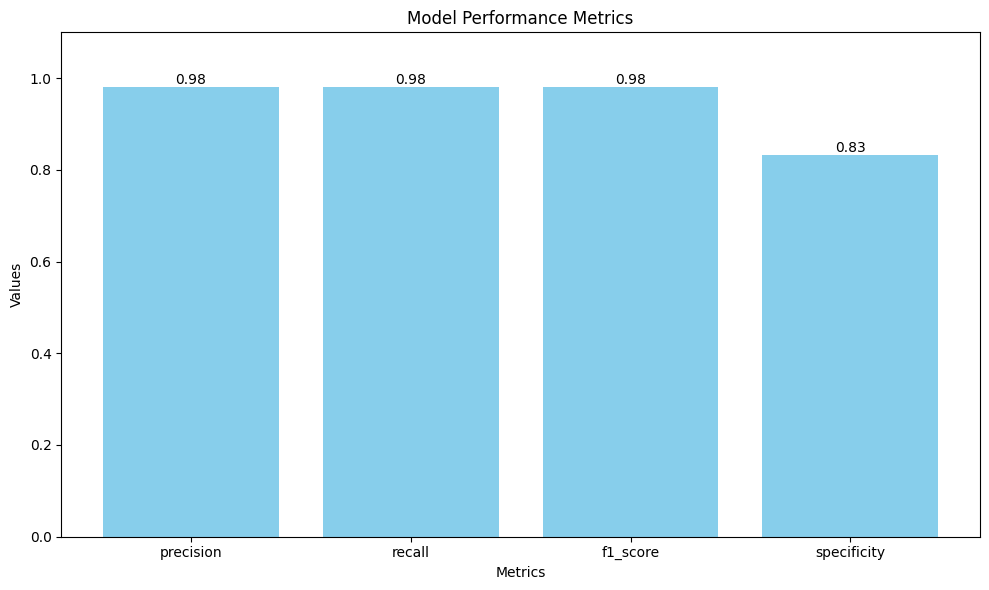

In [ ]:
# Create a copy of the metrics dictionary
metrics_copy = metrics.copy()

# Remove specified keys from the copy
keys_to_remove = ['true_positives', 'false_positives', 'false_negatives', 'true_negatives']
for key in keys_to_remove:
    metrics_copy.pop(key, None)

# Data preparation
metric_names = list(metrics_copy.keys())
metric_values = list(metrics_copy.values())

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color='skyblue')

# Adding the value labels on top of each bar
for i, value in enumerate(metric_values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Adding titles and labels
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1.1)  # Set y-axis limit to show values clearly at the top of the bars

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
metrics

{'true_positives': 49,
 'false_positives': 1,
 'false_negatives': 1,
 'true_negatives': 5,
 'precision': 0.98,
 'recall': 0.98,
 'f1_score': 0.98,
 'specificity': 0.8333333333333334}

In [ ]:
import matplotlib.pyplot as plt

# Data preparation
configs = [f'{res["params"]["num_nodes"]} Nodes\n{res["params"]["num_echo_chambers"]} Echo Chambers' for res in positive_results]
actual_chambers = [res['params']['num_echo_chambers'] for res in positive_results]
detected_chambers = [len(res['detected_chambers']) for res in positive_results]

# Detected Echo Chambers vs. Actual
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(configs))
plt.bar(index, actual_chambers, bar_width, label='Actual')
plt.bar([i + bar_width for i in index], detected_chambers, bar_width, label='Detected')
plt.xlabel('Simulation Configurations')
plt.ylabel('Number of Echo Chambers')
plt.xticks([i + bar_width / 2 for i in index], configs)
plt.legend()
plt.title('Detected vs Actual Number of Echo Chambers')
plt.show()

# Size Distribution of Detected Echo Chambers
plt.figure(figsize=(10, 6))
sizes = [len(chamber) for result in positive_results for chamber in result['detected_chambers']]
plt.hist(sizes, bins=range(1, max(sizes) + 2), align='left')
plt.xlabel('Size of Echo Chambers')
plt.ylabel('Frequency')
plt.title('Size Distribution of Detected Echo Chambers')
plt.show()


In [ ]:
from io import StringIO

In [ ]:
community_metrics_a = """graph_size,echo_chamber_strength,density,homogeneity,external_connections,ecc,gec,average_exposure,size
846,3.4551,0.4167,0.26,0.75,0.3333,0.1379,0.3333,9
846,3.8192,0.3611,0.4446,0.6842,0.3333,0.1379,0.3333,9
846,3.7734,0.4643,0.2425,0.8387,0.375,0.1379,0.3958,8
846,6.4658,0.4643,0.8333,0.7879,0,0.1379,0.3125,8
846,4.1124,0.4643,0.329,0.8387,0.25,0.1379,0.3611,8
846,4.8538,0.4643,0.4951,0.8387,0.25,0.1379,0.35,8
846,4.3198,0.4643,0.4528,0.7647,0.25,0.1379,0.3036,8
846,6.2904,1,1,0.4088,1.5,0.1379,0.2134,8
846,4.1774,0.4762,0.4654,0.7143,0.2857,0.1379,0.3265,7
846,4.906,0.5238,0.5656,0.7586,0.5714,0.1379,0.3333,7
846,4.6399,0.5238,0.4528,0.8148,0.2857,0.1379,0.4286,7
846,4.6243,0.5238,0.4179,0.8462,0.2857,0.1379,0.4643,7
846,5.671,0.4286,0.7509,0.75,0.4286,0.1379,0.3714,7
846,4.0155,0.5238,0.3379,0.7857,0.2857,0.1379,0.4,7
846,4.9184,0.5238,0.541,0.7857,0.2857,0.1379,0.3571,7
846,6.4259,0.5238,0.7795,0.8148,0.4286,0.1379,0.3143,7
846,5.5464,0.5238,0.7143,0.7333,0,0.1379,0.3143,7
846,4.1007,0.5238,0.4118,0.7333,0.2857,0.1379,0.3393,7
846,3.451,0.4286,0.3129,0.6923,0.1429,0.1379,0.3036,7
846,3.9645,0.5238,0.3516,0.7586,0.2857,0.1379,0.449,7
846,4.2212,0.4762,0.4192,0.7692,0.7143,0.1379,0.4694,7
846,2.784,0.5238,0,0.7586,0.1429,0.1379,0.2857,7
846,3.8186,0.5238,0.2885,0.7857,0.2857,0.1379,0.2857,7
846,4.1887,0.5238,0.3503,0.8148,0,0.1379,0.5,7
846,4.1895,0.5238,0.3503,0.8148,0.4286,0.1379,0.4286,7
846,6.7385,0.5238,0.9091,0.7333,0.2857,0.1379,0.2653,7
846,6.0571,1,1,0.375,1.1429,0.1379,0.1939,7
846,5.5771,1,1,0.2917,1.5714,0.1379,0.2208,7
846,5.6701,1,1,0.3088,1.2857,0.1379,0.1929,7
846,2.7487,0.6,0,0.72,0.1667,0.1379,0.2917,6
846,4.3238,0.6,0.3884,0.7826,0,0.1379,0.5,6
846,5.2649,0.6,0.6186,0.75,0.3333,0.1379,0.3889,6
846,4.0937,0.6,0.3653,0.75,0.3333,0.1379,0.5833,6
846,3.6759,0.6,0.2581,0.75,0.5,0.1379,0.4762,6
846,4.1567,0.6,0.3503,0.7826,0.1667,0.1379,0.3667,6
846,5.1937,0.6,0.6623,0.6923,0.3333,0.1379,0.4333,6
846,5.1085,0.5333,0.6667,0.6957,0,0.1379,0.3125,6
846,5.2737,0.4667,0.8333,0.5833,0.1667,0.1379,0.2857,6
846,2.8323,0.6,0,0.75,0.1667,0.1379,0.2778,6
846,3.5468,0.6,0.3059,0.6667,0.3333,0.1379,0.5,6
846,3.9048,0.6,0.3775,0.6923,0.3333,0.1379,0.4048,6
846,4.2563,0.6,0.4635,0.6923,0.1667,0.1379,0.4286,6
846,7.2866,0.6,1,0.6923,0.3333,0.1379,0.5,6
846,2.9236,0.6,0,0.7826,0,0.1379,0.2222,6
846,4.5155,0.6,0.4654,0.75,0,0.1379,0.4167,6
846,4.2549,0.6,0.4881,0.6667,0.5,0.1379,0.4583,6
846,3.6188,0.6,0.3016,0.6923,0.3333,0.1379,0.3704,6
846,5.8769,0.6,0.7277,0.75,0.3333,0.1379,0.4667,6
846,3.5201,0.4667,0.3741,0.6364,0.5,0.1379,0.4524,6
846,3.6391,0.6,0.2155,0.7826,0,0.1379,0.5625,6
846,6.7843,0.6,0.8032,0.8182,0.3333,0.1379,0.4667,6
846,5.9861,0.6,0.7143,0.7826,0,0.1379,0.4583,6
846,5.2357,0.6,0.6712,0.6923,0,0.1379,0.4048,6
846,4.594,0.6,0.4815,0.75,0,0.1379,0.5333,6
846,5.1449,0.6,0.625,0.72,0,0.1379,0.5,6
846,4.4642,0.6,0.5376,0.6667,0,0.1379,0.3889,6
846,4.8222,0.6,0.5595,0.72,0.3333,0.1379,0.5417,6
846,3.8795,0.6,0.3134,0.75,0,0.1379,0.4333,6
846,5.6378,1,1,0.303,1.1667,0.1379,0.2135,6
846,4.9288,0.6,0.4825,0.8182,0.5,0.1379,0.5833,6
846,5.9269,0.7,0.7143,0.7368,0,0.1379,0.65,5
846,5.1802,0.7,0.6186,0.7,0.4,0.1379,0.4,5
846,3.5149,0.7,0.3214,0.6087,0.2,0.1379,0.4667,5
846,6.427,0.7,0.8333,0.7,0.4,0.1379,0.5,5
846,4.7146,0.7,0.5233,0.7,0,0.1379,0.5667,5
846,5.0129,0.7,0.6186,0.6667,0.4,0.1379,0.4286,5
846,3.7494,0.7,0.2936,0.7,0.6,0.1379,0.5333,5
846,3.8573,0.7,0.3571,0.6667,0,0.1379,0.425,5
846,4.6283,0.7,0.5376,0.6667,0.4,0.1379,0.56,5
846,5.4291,0.6,0.7692,0.6316,0,0.1379,0.3,5
846,3.8429,0.7,0.2824,0.7368,0,0.1379,0.5143,5
846,4.2164,0.7,0.4762,0.6364,0,0.1379,0.4667,5
846,7.8855,0.7,1,0.7368,0.4,0.1379,0.6,5
846,3.6444,0.7,0.3303,0.6364,0,0.1379,0.475,5
846,3.9508,0.7,0.437,0.6087,0.4,0.1379,0.5667,5
846,3.7688,0.7,0.3005,0.7,0,0.1379,0.4333,5
846,4.1272,0.7,0.3543,0.7368,0.6,0.1379,0.4,5
846,4.9014,0.7,0.5263,0.7368,0,0.1379,0.4667,5
846,4.8092,0.7,0.6068,0.6364,0.4,0.1379,0.5,5
846,4.0894,0.6,0.4495,0.6667,0.4,0.1379,0.3667,5
846,5.5914,0.7,0.7277,0.6667,0.4,0.1379,0.4667,5
846,3.9122,0.7,0.37,0.6667,0.6,0.1379,0.5,5
846,6.9293,0.7,0.9091,0.7,0,0.1379,0.48,5
846,6.9218,0.7,0.9091,0.7,0.2,0.1379,0.36,5
846,2.7954,0.7,0,0.7,0.2,0.1379,0.6,5
846,4.3908,0.7,0.4528,0.7,0,0.1379,0.48,5
846,5.2371,0.7,0.6283,0.7,0.6,0.1379,0.5,5
846,3.9823,0.7,0.4173,0.6364,0.4,0.1379,0.5667,5
846,3.891,0.7,0.2934,0.7368,0.6,0.1379,0.6,5
846,4.054,0.7,0.4049,0.6667,0.6,0.1379,0.5667,5
846,2.7885,0.7,0,0.7,0.2,0.1379,0.35,5
846,4.1328,0.6,0.5556,0.5714,0,0.1379,0.4,5
846,5.5434,0.6,0.7143,0.7059,0.4,0.1379,0.4,5
846,3.8399,0.7,0.3185,0.7,0.4,0.1379,0.48,5
846,3.5241,0.7,0.2956,0.6364,0.4,0.1379,0.5143,5
846,6.2038,0.7,0.8333,0.6667,0,0.1379,0.3429,5
846,2.7875,0.7,0,0.7,0.2,0.1379,0.3143,5
846,5.2108,0.7,0.625,0.7,0,0.1379,0.4,5
846,4.7881,0.7,0.572,0.6667,0.2,0.1379,0.5333,5
846,4.4427,0.6,0.531,0.6667,0.2,0.1379,0.52,5
846,2.6969,0.7,0,0.6667,0.2,0.1379,0.3333,5
846,3.435,0.7,0.2986,0.6087,0,0.1379,0.4857,5
846,7.1809,0.7,0.9091,0.7368,0,0.1379,0.36,5
846,4.781,0.7,0.5013,0.7368,0,0.1379,0.4857,5
846,4.6102,0.7,0.4635,0.7368,0.4,0.1379,0.56,5
846,6.935,0.7,0.9091,0.7,0,0.1379,0.5333,5
846,3.8232,0.7,0.3147,0.7,0.2,0.1379,0.425,5
846,4.3299,0.6,0.541,0.6316,0,0.1379,0.5,5
846,5.1355,0.7,0.572,0.7368,0.4,0.1379,0.5,5
846,5.8483,0.7,0.7021,0.7368,0.2,0.1379,0.52,5
846,4.1836,0.7,0.3664,0.7368,0,0.1379,0.6,5
846,5.3796,0.7,0.6186,0.7368,0.6,0.1379,0.4333,5
846,4.2576,0.7,0.3828,0.7368,0.6,0.1379,0.6667,5
846,4.939,1,1,0.1695,1.8,0.1379,0.2605,5
846,4.3707,0.7,0.4106,0.7368,0.4,0.1379,0.52,5
846,5.5017,0.7,0.6387,0.7368,0.4,0.1379,0.7333,5
846,4.3053,0.8333,0.5,0.5882,0,0.1379,0.4583,4
846,5.335,0.8333,0.7143,0.5882,0,0.1379,0.5,4
846,5.2291,0.6667,0.7692,0.5714,0,0.1379,0.3125,4
846,5.0875,0.8333,0.5882,0.6667,0.5,0.1379,0.4583,4
846,4.958,0.6667,0.7143,0.5714,0.5,0.1379,0.4167,4
846,5.4548,0.8333,0.7692,0.5556,0,0.1379,0.5,4
846,4.6286,0.8333,0.572,0.5882,0.5,0.1379,0.4722,4
846,2.7124,0.8333,0,0.625,0.25,0.1379,0.5833,4
846,3.9619,0.8333,0.2896,0.7143,0.25,0.1379,0.5833,4
846,2.7074,0.8333,0,0.625,0.25,0.1379,0.4,4
846,3.9974,0.8333,0.4257,0.5882,0.5,0.1379,0.4167,4
846,5.1851,0.8333,0.6068,0.6667,0.5,0.1379,0.5,4
846,4.949,0.8333,0.5595,0.6667,0.75,0.1379,0.5417,4
846,2.8182,0.8333,0,0.6667,0,0.1379,0.25,4
846,2.8296,0.8333,0,0.6667,0.25,0.1379,0.625,4
846,4.3986,0.8333,0.4836,0.625,0.5,0.1379,0.5357,4
846,5.087,0.8333,0.5882,0.6667,0,0.1379,0.5,4
846,6.2392,0.8333,0.8333,0.625,0.25,0.1379,0.55,4
846,5.6103,0.8333,0.7277,0.625,0.5,0.1379,0.4583,4
846,7.3575,0.8333,0.9091,0.7143,0,0.1379,0.5625,4
846,5.7644,0.8333,0.7143,0.6667,0,0.1379,0.4,4
846,3.9362,0.6667,0.3884,0.6667,0,0.1379,0.45,4
846,3.8439,0.8333,0.3053,0.6667,0.25,0.1379,0.75,4
846,4.2452,0.8333,0.4495,0.625,0.25,0.1379,0.4286,4
846,2.605,0.8333,0,0.5882,0,0.1379,0.25,4
846,4.2507,0.8333,0.5188,0.5556,0.75,0.1379,0.5,4
846,5.2809,0.8333,0.625,0.6667,0,0.1379,0.55,4
846,5.8507,0.8333,0.7692,0.625,0,0.1379,0.5625,4
846,4.2575,0.8333,0.3615,0.7143,0.5,0.1379,0.5417,4
846,6.8171,0.8333,0.8761,0.6667,0.5,0.1379,0.9167,4
846,4.3058,0.8333,0.5,0.5882,0,0.1379,0.5,4
846,2.8177,0.8333,0,0.6667,0,0.1379,0.25,4
846,5.7738,0.8333,0.7143,0.6667,0,0.1379,0.5625,4
846,6.5756,1,0.9091,0.5455,0,0.1379,0.5833,3
846,3.3325,0.6667,0.5556,0.3333,0,0.1379,0.4286,3
846,4.2907,1,0.5263,0.5,0,0.1379,0.6667,3
846,2.6425,1,0,0.5455,0,0.1379,0.3333,3
846,2.5307,1,0,0.5,0.3333,0.1379,0.4667,3
846,3.8823,1,0.5,0.4286,0,0.1379,0.4583,3
846,2.6425,1,0,0.5455,0,0.1379,0.3333,3
846,4.4351,1,1,0.0606,2,0.1379,0.3643,3
846,4.43,1,1,0.06,1.6667,0.1379,0.3481,3
846,2.6227,0.6667,0.3129,0.3333,0.6667,0.1379,0.6667,3
846,2.5284,1,0,0.5,0.3333,0.1379,0.4,3"""
csv_file = StringIO(community_metrics_a)
df = pd.read_csv(csv_file)
print(df)

     graph_size  echo_chamber_strength  density  homogeneity  \
0           846                 3.4551   0.4167       0.2600   
1           846                 3.8192   0.3611       0.4446   
2           846                 3.7734   0.4643       0.2425   
3           846                 6.4658   0.4643       0.8333   
4           846                 4.1124   0.4643       0.3290   
..          ...                    ...      ...          ...   
155         846                 2.6425   1.0000       0.0000   
156         846                 4.4351   1.0000       1.0000   
157         846                 4.4300   1.0000       1.0000   
158         846                 2.6227   0.6667       0.3129   
159         846                 2.5284   1.0000       0.0000   

     external_connections     ecc     gec  average_exposure  size  
0                  0.7500  0.3333  0.1379            0.3333     9  
1                  0.6842  0.3333  0.1379            0.3333     9  
2                  0.8387  

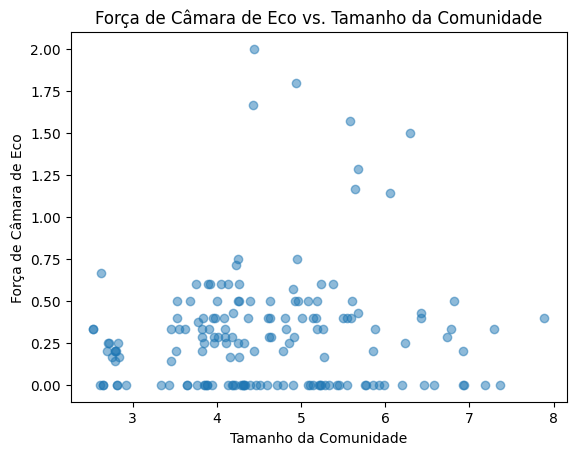

In [ ]:
import matplotlib.pyplot as plt

# Substitua 'df' pelo nome do seu DataFrame
plt.scatter(df['echo_chamber_strength'], df['ecc'], alpha=0.5)
plt.xlabel('Tamanho da Comunidade')
plt.ylabel('Força de Câmara de Eco')
plt.title('Força de Câmara de Eco vs. Tamanho da Comunidade')

plt.show()


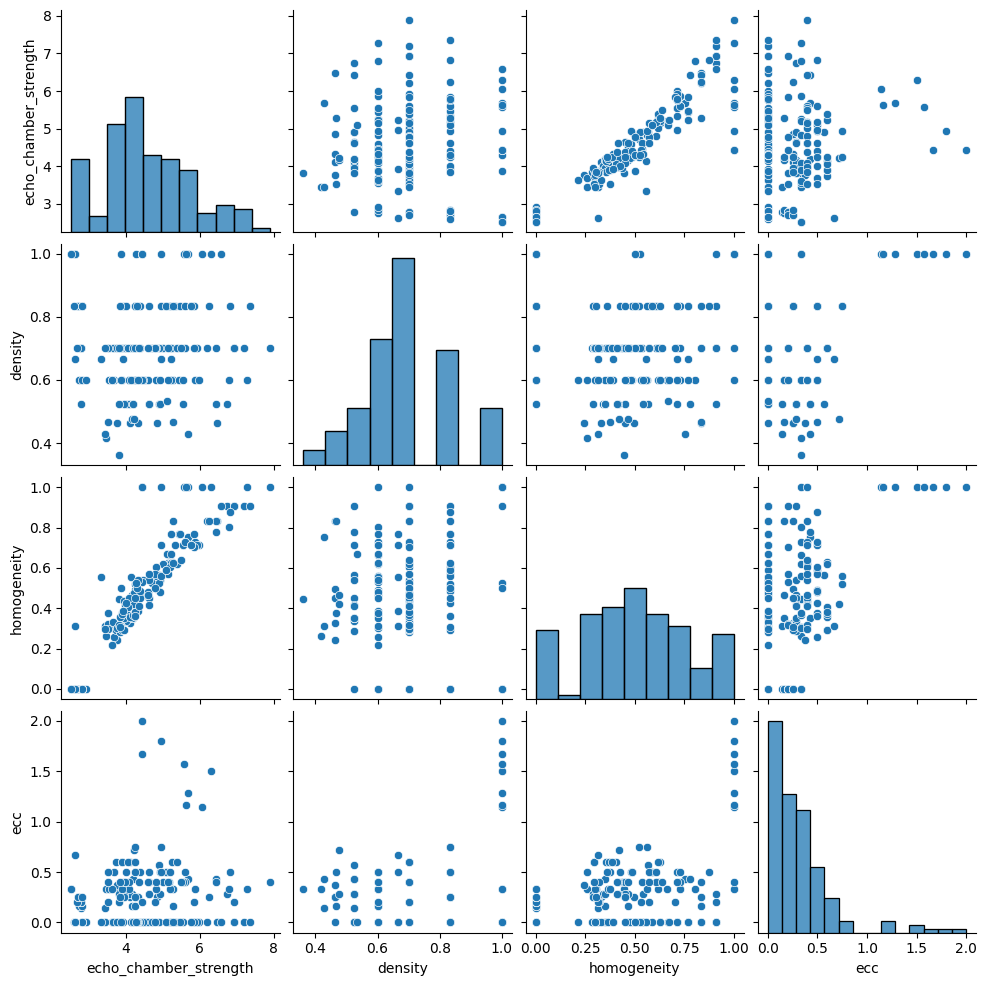

In [ ]:
import seaborn as sns

# Substitua 'df' pelo nome do seu DataFrame
sns.pairplot(df, vars=['echo_chamber_strength', 'density', 'homogeneity', 'ecc'])
plt.show()


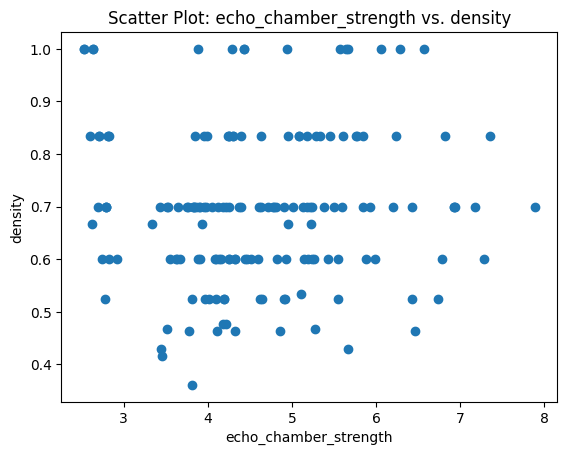

In [ ]:
import matplotlib.pyplot as plt

# Substitua 'df' pelo nome do seu DataFrame
plt.scatter(df['echo_chamber_strength'], df['density'])
plt.xlabel('echo_chamber_strength')
plt.ylabel('density')
plt.title('Scatter Plot: echo_chamber_strength vs. density')
plt.show()


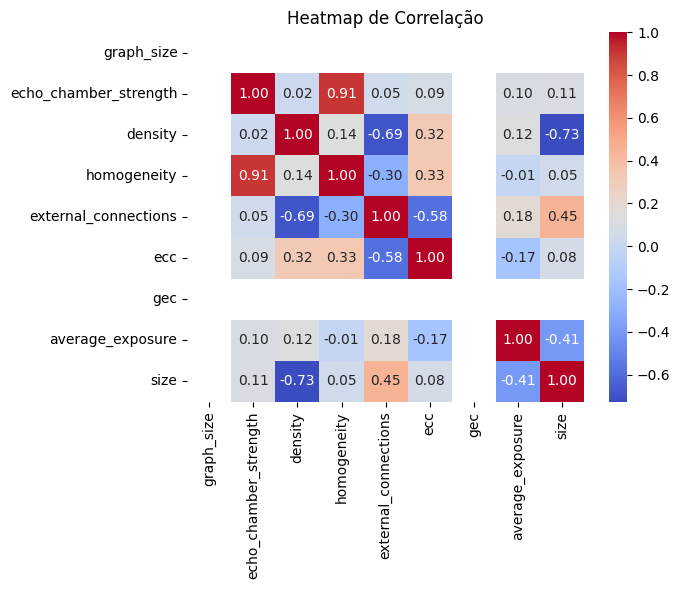

In [ ]:
import seaborn as sns

# Substitua 'df' pelo nome do seu DataFrame
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação')
plt.show()


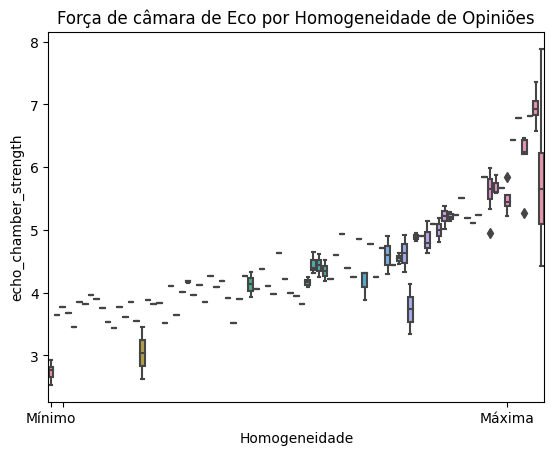

In [ ]:
import seaborn as sns

# Substitua 'df' pelo nome do seu DataFrame
sns.boxplot(x='homogeneity', y='echo_chamber_strength', data=df)
plt.xlabel('Homogeneidade')
plt.ylabel('echo_chamber_strength')
plt.title('Força de câmara de Eco por Homogeneidade de Opiniões')

xticks_labels = ['Mínimo', 'Máxima', '']
plt.xticks([0, len(df) // 2, 2], xticks_labels)

plt.show()


# Load Data

In [ ]:
comments_url = "https://drive.usercontent.google.com/download?id=18vF-9KzvBH1NDnepzVpEKEsHqJnSrZu-&export=download&authuser=3&confirm=t&uuid=16516fb9-e9fa-4f21-9e52-a771b33787c3&at=APZUnTULRxOxdxsScK9nILnflb3q:1694052463506"
# read csv file
colab_comments = pd.read_csv(comments_url, sep=',', decimal='.', header=0, low_memory=False)
print(colab_comments.columns)
print(colab_comments.head(1))
colab_comments

Index(['id', 'created_at', 'colab_user_id_from', 'colab_user_id_to',
       'event_type_id', 'event_id'],
      dtype='object')
     id                created_at  colab_user_id_from  colab_user_id_to  \
0  7175  2014-05-04T00:14:40-0300               32595             28560   

   event_type_id  event_id  
0           1181      6252  


,id,created_at,colab_user_id_from,colab_user_id_to,event_type_id,event_id
0,7175,2014-05-04T00:14:40-0300,32595,28560,1181,6252
1,11259,2014-07-24T13:45:28-0300,40434,40434,3949,8509
2,12165,2014-08-08T12:06:55-0300,41132,40544,60,8464
3,10590,2014-07-09T17:59:25-0300,36998,36998,3920,8039
4,7443,2014-05-07T21:49:46-0300,32968,32065,3940,6370
...,...,...,...,...,...,...
334677,33749,2015-03-08T21:56:35-0300,75404,63081,1190,18222
334678,119668,2016-03-10T19:05:41-0300,114778,114778,4973,50642
334679,25352,2015-01-11T20:06:05-0200,63405,62718,1214,14446
334680,25354,2015-01-11T20:12:23-0200,63405,62535,1214,14389


In [ ]:
likes_url = "https://drive.usercontent.google.com/download?id=1jBjbR_jZQZNsMdpk9e5UuOlfSoMGPIsm&export=download&authuser=3&confirm=t&uuid=16516fb9-e9fa-4f21-9e52-a771b33787c3&at=APZUnTULRxOxdxsScK9nILnflb3q:1694052463506"
# read csv file
colab_likes = pd.read_csv(likes_url, sep=',', decimal='.', header=0, low_memory=False)
print(colab_likes.columns)
print(colab_likes.head(1))
colab_likes

Index(['id', 'created_at', 'colab_user_id_from', 'colab_user_id_to',
       'event_type_id', 'event_id'],
      dtype='object')
      id                created_at  colab_user_id_from  colab_user_id_to  \
0  21262  2014-05-11T01:39:04-0300               29163             27334   

   event_type_id  event_id  
0           1214      6456  


,id,created_at,colab_user_id_from,colab_user_id_to,event_type_id,event_id
0,21262,2014-05-11T01:39:04-0300,29163,27334,1214,6456
1,20696,2014-05-08T11:41:22-0300,32994,14375,3920,6394
2,20814,2014-05-08T23:51:51-0300,32092,32092,7575,6401
3,21258,2014-05-11T01:22:15-0300,33018,33018,1363,6428
4,21277,2014-05-11T04:01:42-0300,32977,3699,7586,6463
...,...,...,...,...,...,...
1048570,1223098,2021-11-24T21:59:42-0300,186310,186310,9954,329797
1048571,1302647,2022-02-08T15:04:38-0300,186310,231120,9908,173883
1048572,1307278,2022-02-11T17:07:36-0300,415276,268969,9926,349198
1048573,1307563,2022-02-11T17:28:34-0300,415276,264351,432,336844


In [ ]:
updown_url = "https://drive.usercontent.google.com/download?id=1eM6AwfPYlmfrqQOuop9Im46AedYe_E93&export=download&authuser=3&confirm=t&uuid=eed60c3f-bce1-46cd-83eb-a9c33bd55df9&at=APZUnTVojRNJK9ALj7DRZ_D5is--:1694050615548"
colab_updown = pd.read_csv(updown_url)
print(colab_updown.columns)
print(colab_updown.head(1))
colab_updown

Index(['id', 'created_at', 'colab_user_id_from', 'colab_user_id_to',
       'event_id', 'event_type_id', 'colab_user_event', 'comment_id', 'vote'],
      dtype='object')
   id                created_at  colab_user_id_from  colab_user_id_to  \
0  28  2021-08-04T21:02:21-0300              236585               NaN   

   event_id  event_type_id  colab_user_event  comment_id vote  
0  300071.0         1689.0           76184.0      849707   UP  


,id,created_at,colab_user_id_from,colab_user_id_to,event_id,event_type_id,colab_user_event,comment_id,vote
0,28,2021-08-04T21:02:21-0300,236585,NaN,300071.0,1689.0,76184.0,849707,UP
1,35,2021-08-05T00:43:11-0300,323968,313537.0,217188.0,3353.0,313537.0,591072,UP
2,50,2021-08-05T00:44:51-0300,323968,429282.0,217188.0,3353.0,313537.0,836739,UP
3,76,2021-08-05T16:55:47-0300,202266,NaN,153045.0,7578.0,202266.0,416256,UP
4,89,2021-08-05T21:27:10-0300,222051,222051.0,164113.0,3332.0,222051.0,838576,UP
...,...,...,...,...,...,...,...,...,...
58680,35344,2022-06-02T01:23:08-0300,227897,NaN,378589.0,3327.0,227897.0,1074711,UP
58681,35347,2022-06-02T02:32:44-0300,116186,262480.0,NaN,NaN,NaN,1027219,DOWN
58682,35350,2022-06-02T03:03:05-0300,688906,689179.0,376664.0,11652.0,689179.0,1068924,UP
58683,35351,2022-06-02T03:20:54-0300,688906,NaN,377119.0,11652.0,684855.0,1070466,UP


In [ ]:
events_url = "https://drive.google.com/uc?export=download&id=1z75LjlZZ8oPqixtslWwZWwItMWmK-ooO"
#events_url = "spider_df.csv"
events = pd.read_csv(events_url, sep=',', decimal='.', header=0)
print(events.head())
print(events.columns)
events

NameError: ignored

In [ ]:
# 1. Obter os IDs únicos de event_id do dataframe events.
unique_event_ids = events['event_id'].unique()

# 2. Filtrar cada um dos outros dataframes.

# Filtrar colab_comments
colab_comments = colab_comments[colab_comments['event_id'].isin(unique_event_ids)]

# Filtrar colab_likes
colab_likes = colab_likes[colab_likes['event_id'].isin(unique_event_ids)]

# Filtrar colab_updown
colab_updown = colab_updown[colab_updown['event_id'].isin(unique_event_ids)]

print("Número de linhas em filtered_colab_comments:", colab_comments.shape[0])
print("Número de linhas em filtered_colab_likes:", colab_likes.shape[0])
print("Número de linhas em filtered_colab_updown:", colab_updown.shape[0])

In [ ]:
url_edges = "https://drive.google.com/uc?id=1skMWv0IDbMZ-Gl3f2BzCVScmK6cZPakd&export=download" # gephi
edges = pd.read_csv(url_edges, sep=',', decimal='.', header=0)
print(edges.columns)
edges

Index(['source', 'target'], dtype='object')


,source,target
0,113450,162519
1,113450,118923
2,113450,40367
3,113450,123242
4,113450,39850
...,...,...
25780,248233,58898
25781,248233,60405
25782,321685,284896
25783,321685,291751


In [ ]:
url_nodes = "https://drive.google.com/uc?id=1C04iiMkjoWStAbL19RcIAAE2uOnITejr&export=download"
nodes = pd.read_csv(url_nodes, sep=',', decimal='.', header=0)
nodes = nodes[nodes['colab_user_id'].isin(edges['source']) | nodes['colab_user_id'].isin(edges['target'])]
print(nodes.columns)
nodes

In [ ]:

events['colab_user_id'] = events['colab_user_id'].astype(str)
colab_comments['colab_user_id_from'] = colab_comments['colab_user_id_from'].astype(str)
colab_likes['colab_user_id_from'] = colab_likes['colab_user_id_from'].astype(str)
colab_updown['colab_user_id_from'] = colab_updown['colab_user_id_from'].astype(str)
colab_comments['colab_user_id_to'] = colab_comments['colab_user_id_to'].astype(str)
colab_likes['colab_user_id_to'] = colab_likes['colab_user_id_to'].astype(str)
colab_updown['colab_user_id_to'] = colab_updown['colab_user_id_to'].astype(str)
nodes['colab_user_id'] = nodes['colab_user_id'].astype(str)
edges['source'] = edges['source'].astype(str)
edges['target'] = edges['target'].astype(str)

# 3 CIDADES

In [ ]:
# Merge events with nodes on colab_user_id
merged_df = events.merge(nodes[['colab_user_id', 'city']], on='colab_user_id', how='inner')
# 1. Reverter os índices duplos/triplos para colunas
merged_df.reset_index(inplace=True)

# 2. Converter as colunas para int
merged_df['event_id'] = merged_df['event_id'].astype(str)
merged_df['colab_user_id'] = merged_df['colab_user_id'].astype(str)
merged_df['event_type_id'] = merged_df['event_type_id'].astype(str)

print(merged_df.columns)
merged_df

Index(['index', 'Unnamed: 0', 'event_id', 'colab_user_id', 'persona',
       'persona_value', 'description', 'score', 'event_type_id',
       'event_type_name', 'city'],
      dtype='object')


,index,Unnamed: 0,event_id,colab_user_id,persona,persona_value,description,score,event_type_id,event_type_name,city
0,0,0,41,86,helper,0.0,Árvore bloqueando a calçada,-0.03574,7574,Poda de árvore,Niterói
1,1,2,58,86,helper,0.0,Utilização da calçada para estacionamento. Pad...,-0.04684,7558,Ocupação irregular de área pública,Niterói
2,2,3,582,86,helper,0.0,"Árvore batendo na fiação, que já está toda bag...",-0.13990,3942,Poda de árvore,Niterói
3,3,4,918,86,helper,0.0,Entulho na calçada e o pedestre tem que passar...,-0.19282,3938,Entulho na calçada/via pública,Niterói
4,4,5,919,86,complainer,1.0,"É bom ter ciclofaixas nas avenidas, mas quando...",0.27672,3921,Ocupação irregular de área pública,Niterói
...,...,...,...,...,...,...,...,...,...,...,...
132853,132853,132853,258206,293209,complainer,1.0,Vizinho fez uma reforma na casa e simplesmente...,-0.63388,9,Entulho na calçada/via pública,Santo André
132854,132854,132854,274342,319241,complainer,1.0,"Porque não coloca GCM, uma Base nessa praça? ...",-0.08944,56,Ponto de exploração sexual de menores,Santo André
132855,132855,132855,285040,197268,helper,0.0,"Olá, no telhado do imóvel localizado na avenid...",-0.12818,54,Infestação animais perigosos,Mesquita
132856,132856,132856,284833,95084,helper,0.0,"Boa tarde, no sambaqui de Balneario arroio do ...",0.40797,46,Mato alto,Santo André


In [ ]:
# Filtrar as linhas para Niterói
niteroi_df = merged_df[merged_df['city'] == 'Niterói']

# Filtrar as linhas para Santo André
santo_andre_df = merged_df[merged_df['city'] == 'Santo André']

# Filtrar as linhas para Mesquita
mesquita_df = merged_df[merged_df['city'] == 'Mesquita']

# MESQUITA

In [ ]:
detect_echo_chambers(mesquita_df)

DiGraph with 933 nodes and 3578 edges
Analysing Communities...
Number of communities: 79
Time taken: 0.09 seconds


number_of_communities: 79
largest_community_size: 32
smallest_community_size: 3
average_community_size: 5.784810126582278
Comments: 40924
Likes: 156865
Votes: 10355
Deriving Betas...
graph modularity 0.4905825792012841
beta1: 0.30875321837300485, beta2: 0.047619047619047616, beta3:0.5, beta4: 0.015713343244753583, beta5: 1, beta6: 0.4905825792012841, beta7: 0.0010718113612004287
Number of communities after filtering: 79
Calculating graph echo chamber strength...
Global Echo Chamber Coefficient 0.021322451438249866
Graph Echo Chamber Strength 1.0982208823542505
Calculating community metrics...
Community Metrics: [{'echo_chamber_strength': 1.3234, 'density': 0.0343, 'homogeneity': 0.3288, 'external_connections': 0.3585, 'ecc': 0.3288, 'gec': 0.0213, 'average_exposure': 0.0961}, {'echo_chamber_strength': 1.3275, 'density': 0.0427, 'homogeneity': 0.1298, 'external_connections': 0.4, 'ecc': 0.1298, 'gec': 0.0213, 'average_exposure': 0.0805}, {'echo_chamber_strength': 1.5916, 'density': 0.12

[['188553', '328305', '281031'],
 ['334798', '323202', '333167'],
 ['673076', '678051', '765563'],
 ['354769', '339621', '364138'],
 ['208932', '230815', '202954'],
 ['336653', '335081', '311883'],
 ['212649', '483006', '230925'],
 ['669645', '199136', '320732']]

# NITERÓI

In [ ]:
detect_echo_chambers(niteroi_df)

DiGraph with 4274 nodes and 14175 edges
Time taken: 1.37 seconds


number_of_communities: 542
largest_community_size: 159
smallest_community_size: 3
average_community_size: 7.369003690036901
Comments: 80731
Likes: 199668
Votes: 11640
Deriving Betas...
graph modularity 0.5157458947476712
beta1: 0.07893180206948901, beta2: 0.018867924528301886, beta3:0.1111111111111111, beta4: 0.001442148641808398, beta5: 1, beta6: 0.5157458947476712, beta7: 0.0002339728591483388
Number of communities after filtering: 542
Calculating graph echo chamber strength...
Global Echo Chamber Coefficient 0.03213627802331142
Graph Echo Chamber Strength 1.0511694839645198
Community Metrics: [{'echo_chamber_strength': 1.1243, 'density': 0.05, 'homogeneity': 0.3566, 'external_connections': 0.4264, 'ecc': 0.3566, 'gec': 0.0321, 'average_exposure': 0.0509}, {'echo_chamber_strength': 1.1386, 'density': 0.0505, 'homogeneity': 0.3418, 'external_connections': 0.4992, 'ecc': 0.3418, 'gec': 0.0321, 'average_exposure': 0.0602}, {'echo_chamber_strength': 1.1908, 'density': 0.0475, 'homogeneit

[['160509', '337243', '337246']]

# Santo André

In [ ]:
detect_echo_chambers(santo_andre_df)

DiGraph with 2102 nodes and 6430 edges
Analysing Communities...
Number of communities: 243
Time taken: 0.23 seconds


number_of_communities: 243
largest_community_size: 44
smallest_community_size: 3
average_community_size: 6.563786008230453
Comments: 49912
Likes: 165563
Votes: 11222
Deriving Betas...
graph modularity 0.5438427901383788
beta1: 0.20491312771147524, beta2: 0.017543859649122806, beta3:0.07142857142857142, beta4: 0.007472088317700489, beta5: 1, beta6: 0.5438427901383788, beta7: 0.0004757373929590866
Number of communities after filtering: 243
Calculating graph echo chamber strength...
Global Echo Chamber Coefficient 0.04619279583356458
Graph Echo Chamber Strength 1.0743246673473665
Calculating community metrics...
Community Metrics: [{'echo_chamber_strength': 1.1643, 'density': 0.047, 'homogeneity': 0.5891, 'external_connections': 0.6833, 'ecc': 0.5891, 'gec': 0.0462, 'average_exposure': 0.0594}, {'echo_chamber_strength': 1.1131, 'density': 0.025, 'homogeneity': 0.496, 'external_connections': 0.1961, 'ecc': 0.496, 'gec': 0.0462, 'average_exposure': 0.0533}, {'echo_chamber_strength': 1.1675,

[['218378', '219525', '219518'],
 ['354875', '331829', '355617'],
 ['240281', '240531', '242185', '242184'],
 ['285414', '285084', '285462']]

#PCA

In [ ]:
# Convert IDs to a set for faster lookup
selected_ids = set(santo_andre_df['colab_user_id'])

# Direct filtering
edgez = edges[edges['source'].apply(lambda x: x in selected_ids) | edges['target'].apply(lambda x: x in selected_ids)]
edgez

,source,target
275,113450,226175
343,113450,342893
579,186310,313537
648,186310,581155
652,186310,351972
...,...,...
25773,296074,295165
25778,247164,59707
25782,321685,284896
25783,321685,291751


In [ ]:
# Crie um grafo a partir do DataFrame de arestas (edges_df)
G = nx.from_pandas_edgelist(edgez, 'source', 'target', create_using=nx.DiGraph())
print(G)

DiGraph with 2102 nodes and 6430 edges


In [ ]:
strategy = LeidenClusteringStrategy(algo=leidenalg.SignificanceVertexPartition, resolution=1.0, num_iterations=100)
communities = analyse_communities(G, strategy)
print('number_of_communities:', communities['number_of_communities'])
print('largest_community_size:', communities['largest_community_size'])
print('smallest_community_size:', communities['smallest_community_size'])
print('average_community_size:', communities['average_community_size'])
community_sizes = {}
#for i, community in enumerate(communities["communities"], 1):
#    num_nodes_in_community = len(community)
#    community_sizes[f"Comunidade {i}"] = num_nodes_in_community

community_sizes
network_communities = [community for community in communities['communities'] if len(community) >= 3]

Time taken: 4.33 seconds


number_of_communities: 459
largest_community_size: 66
smallest_community_size: 1
average_community_size: 4.579520697167756


In [ ]:
filtered_comments, filtered_likes, filtered_updown = filter_dfs_based_on_edgelist(
    edgez,
    colab_comments,
    colab_likes,
    colab_updown
)

# Print the number of rows for each DataFrame
print(f"Number of rows in filtered_comments: {len(filtered_comments)}")
print(f"Number of rows in filtered_likes: {len(filtered_likes)}")
print(f"Number of rows in filtered_updown: {len(filtered_updown)}")

Number of rows in filtered_comments: 49912
Number of rows in filtered_likes: 165563
Number of rows in filtered_updown: 11222


In [ ]:
# Crie uma instância da classe EchoChamberDetector
@calculate_time_taken
def echo_chambers_print():
  # Identifique as echo chambers
  echo_chambers = echo_chamber_detector.identify_echo_chambers(beta1, beta2, beta3, beta4, beta5, beta6, beta7)
  # Exiba as echo chambers encontradas
  print("Echo Chambers:")
  for i, chamber in enumerate(echo_chambers, 1):
      print(f"Echo Chamber {i}: {len(chamber)}")
  return echo_chambers

In [ ]:
echo_chamber_detector = EchoChamberDetector(
    nodes, edgez, mesquita_df, filtered_comments, filtered_likes, filtered_updown,
    strategy=strategy,
    classifier=echo_chamber_metrics_classifier
    communities=network_communities
)
beta1, beta2, beta3, beta4, beta5, beta6, beta7 = echo_chamber_detector.derive_betas(G)
print(beta1)
print(beta2)
print(beta3)
print(beta4)
print(beta5)
print(beta6)
print(beta7)

In [ ]:
metrics = echo_chamber_detector.community_metrics
df = pd.DataFrame(metrics)
df

,echo_chamber_strength,density,homogeneity,external_connections,ecc,gec,average_exposure
0,1.4956,0.1718,0.5331,0.4901,0.5331,0.0446,0.0510
1,1.2873,0.0341,0.1736,0.3364,0.1736,0.0446,0.0349
2,1.5799,0.0729,0.3103,0.6747,0.3103,0.0446,0.0659
3,1.3543,0.0343,0.3288,0.3585,0.3288,0.0446,0.0961
4,1.3666,0.0446,0.1287,0.4082,0.1287,0.0446,0.0832
...,...,...,...,...,...,...,...
74,1.6638,0.3333,0.3123,0.3333,0.3123,0.0446,0.3563
75,1.9786,0.8333,0.5619,0.1667,0.5619,0.0446,0.5333
76,1.4839,0.5000,0.5017,0.0000,0.5017,0.0446,0.3333
77,2.0185,0.3333,0.2670,0.6667,0.2670,0.0446,0.4167


In [ ]:
print(df)

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=0.95)
pca.fit(scaled_data)
principal_components = pca.transform(scaled_data)
principal_components

In [ ]:
components_df = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(principal_components.shape[1])])
print(components_df)

     echo_chamber_strength   density  homogeneity  external_connections  \
PC1               0.572603  0.540729     0.073610              0.133423   
PC2              -0.275273  0.147203     0.642862             -0.530996   
PC3              -0.190636  0.301247    -0.272619             -0.624877   
PC4               0.179094 -0.157977     0.706766              0.173010   

          ecc  gec  average_exposure  
PC1  0.226851  0.0          0.552319  
PC2  0.455322 -0.0         -0.003149  
PC3 -0.554271 -0.0          0.317648  
PC4 -0.636107  0.0          0.094268  


In [ ]:
print(pca.explained_variance_ratio_)

[0.4129294  0.28843426 0.19372062 0.06143144]


In [ ]:
# Criar o DataFrame pca_weights
pca_weights = pd.DataFrame(pca.components_, columns=df.columns)

# Pegar os pesos do PC1
pc1_weights = pca_weights.iloc[0]

# Ponderar cada métrica em df pelos pesos do PC1
for metric in df.columns:
    if metric in pc1_weights:  # Verifique se a métrica está no índice de pc1_weights
        df[metric] = df[metric] * pc1_weights[metric]

# A coluna resultante será uma soma ponderada das métricas selecionadas
metrics_to_sum = ['echo_chamber_strength', 'density', 'homogeneity', 'external_connections', 'ecc', 'gec', 'average_exposure']
df['echo_chamber_index'] = df[metrics_to_sum].sum(axis=1)
df['echo_chamber_index']

0     1.203017
1     0.871870
2     1.163726
3     0.993725
4     0.945722
        ...   
74    1.468017
75    2.069165
76    1.454880
77    1.735352
78    1.844205
Name: echo_chamber_index, Length: 79, dtype: float64

In [ ]:
# Ordenar os valores em ordem decrescente
sorted_indices = df['echo_chamber_index'].sort_values(ascending=False)

# Usando o limite
threshold = 2  # Este é um valor arbitrário, você pode ajustá-lo conforme necessário
probable_echo_chambers_limit = sorted_indices[sorted_indices > threshold]

# Usando percentil
top_percentile = 0.20  # Considere os top 20%
n_top = int(len(df) * top_percentile)
probable_echo_chambers_percentile = sorted_indices.head(n_top)

print("Prováveis echo chambers usando limite:\n", probable_echo_chambers_limit)
print("Prováveis echo chambers usando percentil:\n", probable_echo_chambers_percentile)

Prováveis echo chambers usando limite:
 66    2.349070
54    2.175319
61    2.106606
51    2.077664
75    2.069165
50    2.036064
Name: echo_chamber_index, dtype: float64
Prováveis echo chambers usando percentil:
 66    2.349070
54    2.175319
61    2.106606
51    2.077664
75    2.069165
50    2.036064
52    1.999183
62    1.944212
70    1.930901
69    1.921246
64    1.910846
78    1.844205
58    1.837238
67    1.802101
55    1.782021
Name: echo_chamber_index, dtype: float64


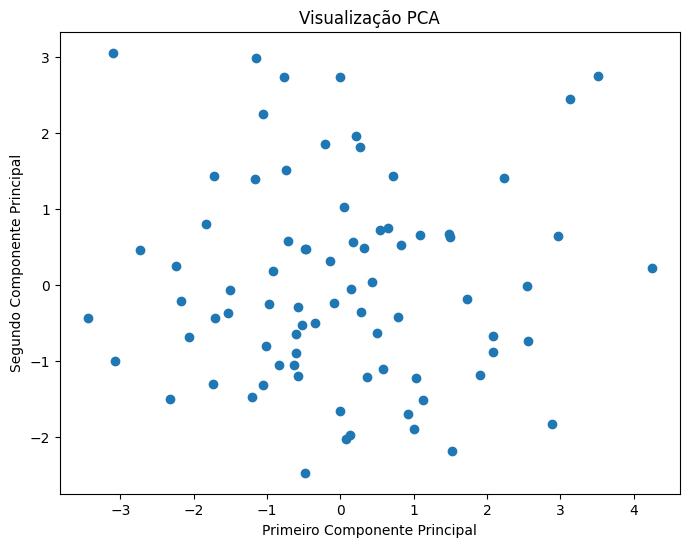

In [ ]:
# Criando um novo DataFrame com os componentes principais
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
plt.figure(figsize=(8,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Primeiro Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.title('Visualização PCA')
plt.show()

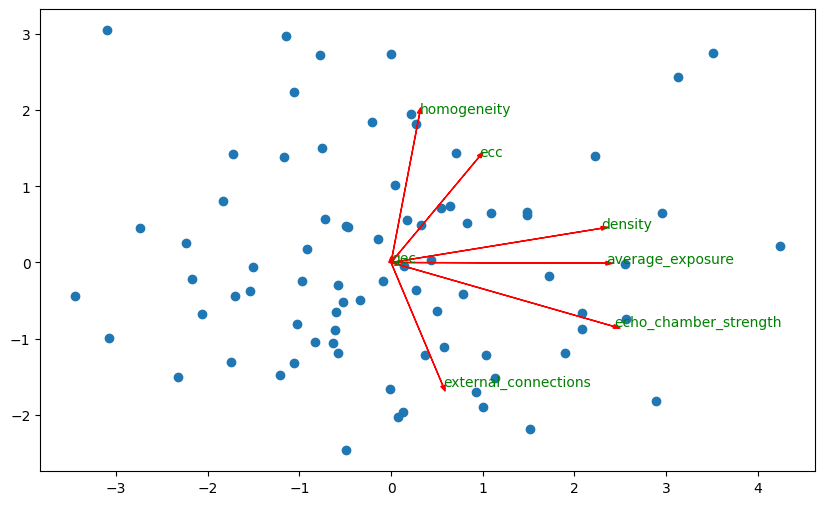

In [ ]:
# Primeiro, plotamos os pontos
plt.figure(figsize=(10,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
# Agora, adicionamos as setas para cada variável
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, x*max(df_pca['PC1']), y*max(df_pca['PC2']), color='r', head_width=0.05)
    plt.text(x*max(df_pca['PC1']), y*max(df_pca['PC2']), df.columns[i], color='g')


In [ ]:
echo_chambers_metrics = echo_chambers_print()

# Testing stuff

In [ ]:
echo_chamber_detector.beta1 = beta1
echo_chamber_detector.beta2 = beta2
echo_chamber_detector.beta3 = beta3
echo_chamber_detector.beta4 = beta4
echo_chamber_detector.beta5 = beta5
echo_chamber_detector.beta6 = beta6
echo_chamber_detector.beta7  = beta7
#gec = echo_chamber_detector.calculate_graph_echo_chamber_probability()
#print(gec)

In [ ]:
gec = echo_chamber_detector.calculate_community_gec(echo_chamber_detector.communities[2])
print(gec)

Pairwise product sum: 68.02476932330316
0.0015686560434291055


In [ ]:
proba = echo_chamber_detector.calculate_echo_chamber_probability(echo_chamber_detector.communities[2])
print(proba)

Pairwise product sum: 68.02476932330316
community_size: 34
density: 0.03208556149732621
homogeneity: 0.3370788246576491
external_connections: 0.32075471698113206
ecc: 0.3370788246576491
gec: 0.0015686560434291055
average_exposure: 0.09558823529411764
1.2724968502743101


In [ ]:
# 1. Transformar o DataFrame em um Grafo
G = nx.from_pandas_edgelist(edgez, 'source', 'target', create_using=nx.DiGraph())

# 2. Subsampling do Grafo - exemplo com uma amostra aleatória de nós
# Este é apenas um exemplo, o subsampling exato pode variar de acordo com suas necessidades
sample_size = int(0.2 * len(G.nodes()))
sampled_nodes = np.random.choice(G.nodes(), sample_size, replace=False)
subgraph = G.subgraph(sampled_nodes)

# 3. Transformar o Subgrafo em um DataFrame
edges_sub = nx.to_pandas_edgelist(subgraph)
edges_sub